In [1]:
import glob
import pickle
import pathlib
import collections
import community
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from enum import Enum
from tqdm import tqdm
from scipy import spatial
from operator import itemgetter
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from numpy.linalg.linalg import eig
from sklearn.cluster import KMeans

mcolors = list(mcolors.BASE_COLORS)

In [2]:
rel_data_folder_path = pathlib.Path("./../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
city_network_graphs_undir = city_network_graphs.joinpath('undirected_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_betweenness = checkpoints_folder_path.joinpath('directed_graphs_betweenness')

- **d(integer)**: Straight-line distance between two stops expressed in meters.
- **duration_avg(integer)**: Travel time between stops averaged over all PT vehicles rounded to one second accuracy.
- **n_vehicles(integer)**: Number of PT vehicles that have traveled between two stops within a time interval
- **route_I_counts(list (string))**: A list of route_I's and the number of times each route has operated between two stops. For the network extracts, this data is formatted as a string where each element is written as `route_I:count` and different routes are separated by a comma. An example value for this field is thus `1:3,2:131,10:93`. Please note that the definition of a route varies across the cities provided, and that routes can have deviations from their main paths for instance when traveling to and from a depot.
- **route_I(integer)**: Identifier for a route.

Below is a table extracted from the [Data Paper](https://www.nature.com/articles/sdata201889) about the types of routes.

<img src="./../../data/images/about_transport_data/route-types.png" alt="Route Types" width="60%" title="route-types"/>


## Utility Functions


In [3]:
# Define enum for route types
class RouteType(Enum):
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

# Define function to calculate required metrics
def calculate_city_metrics(city, route_type, city_graph_dir):
    
    # Calculate number of nodes and edges in full graph
    num_nodes = len(city_graph_dir.nodes)
    num_edges = len(city_graph_dir.edges)

    # Calculate in-degree and out-degree for each node in full graph
    in_degrees = dict(city_graph_dir.in_degree())
    out_degrees = dict(city_graph_dir.out_degree())

    # Calculate top and bottom nodes by in-degree and out-degree
    top_in_degree_nodes = sorted(in_degrees.items(), key=lambda x: x[1] if x[1] > 0 else float('-inf'), reverse=True)[:1]
    bottom_in_degree_nodes = sorted(in_degrees.items(), key=lambda x: x[1] if x[1] > 0 else float('inf'))[:1]
    top_out_degree_nodes = sorted(out_degrees.items(), key=lambda x: x[1] if x[1] > 0 else float('-inf'), reverse=True)[:1]
    bottom_out_degree_nodes = sorted(out_degrees.items(), key=lambda x: x[1] if x[1] > 0 else float('inf'))[:1]

    # Calculate average degree
    avg_degree = num_edges / num_nodes

    # median duration
    route_edges = city_graph_dir.edges(data=True)
    median_duration = np.median([edge[2]['duration_avg'] for edge in route_edges])/60
    
    ## diameter
    try:
        dia = nx.diameter(city_graph_dir)
    except:
        dia = float('inf')

    # Create a dictionary with the calculated metrics
    city_metrics = {
        "city": city,
        "route": route_type,
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "median_duration": median_duration,
        "diameter": dia,
        "density": nx.density(city_graph_dir),
        "top_in_degree_nodes": [(city_graph_dir.nodes[node[0]]["name"], node[1]) for node in top_in_degree_nodes],
        "bottom_in_degree_nodes": [(city_graph_dir.nodes[node[0]]["name"], node[1]) for node in bottom_in_degree_nodes],
        "top_out_degree_nodes": [(city_graph_dir.nodes[node[0]]["name"], node[1]) for node in top_out_degree_nodes],
        "bottom_out_degree_nodes": [(city_graph_dir.nodes[node[0]]["name"], node[1]) for node in bottom_out_degree_nodes]   
    }
    
    return city_metrics

In [4]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir)
cities_graphs_undir = load_all_cities_graphs(cities, city_network_graphs_undir)

25it [00:02, 10.11it/s]


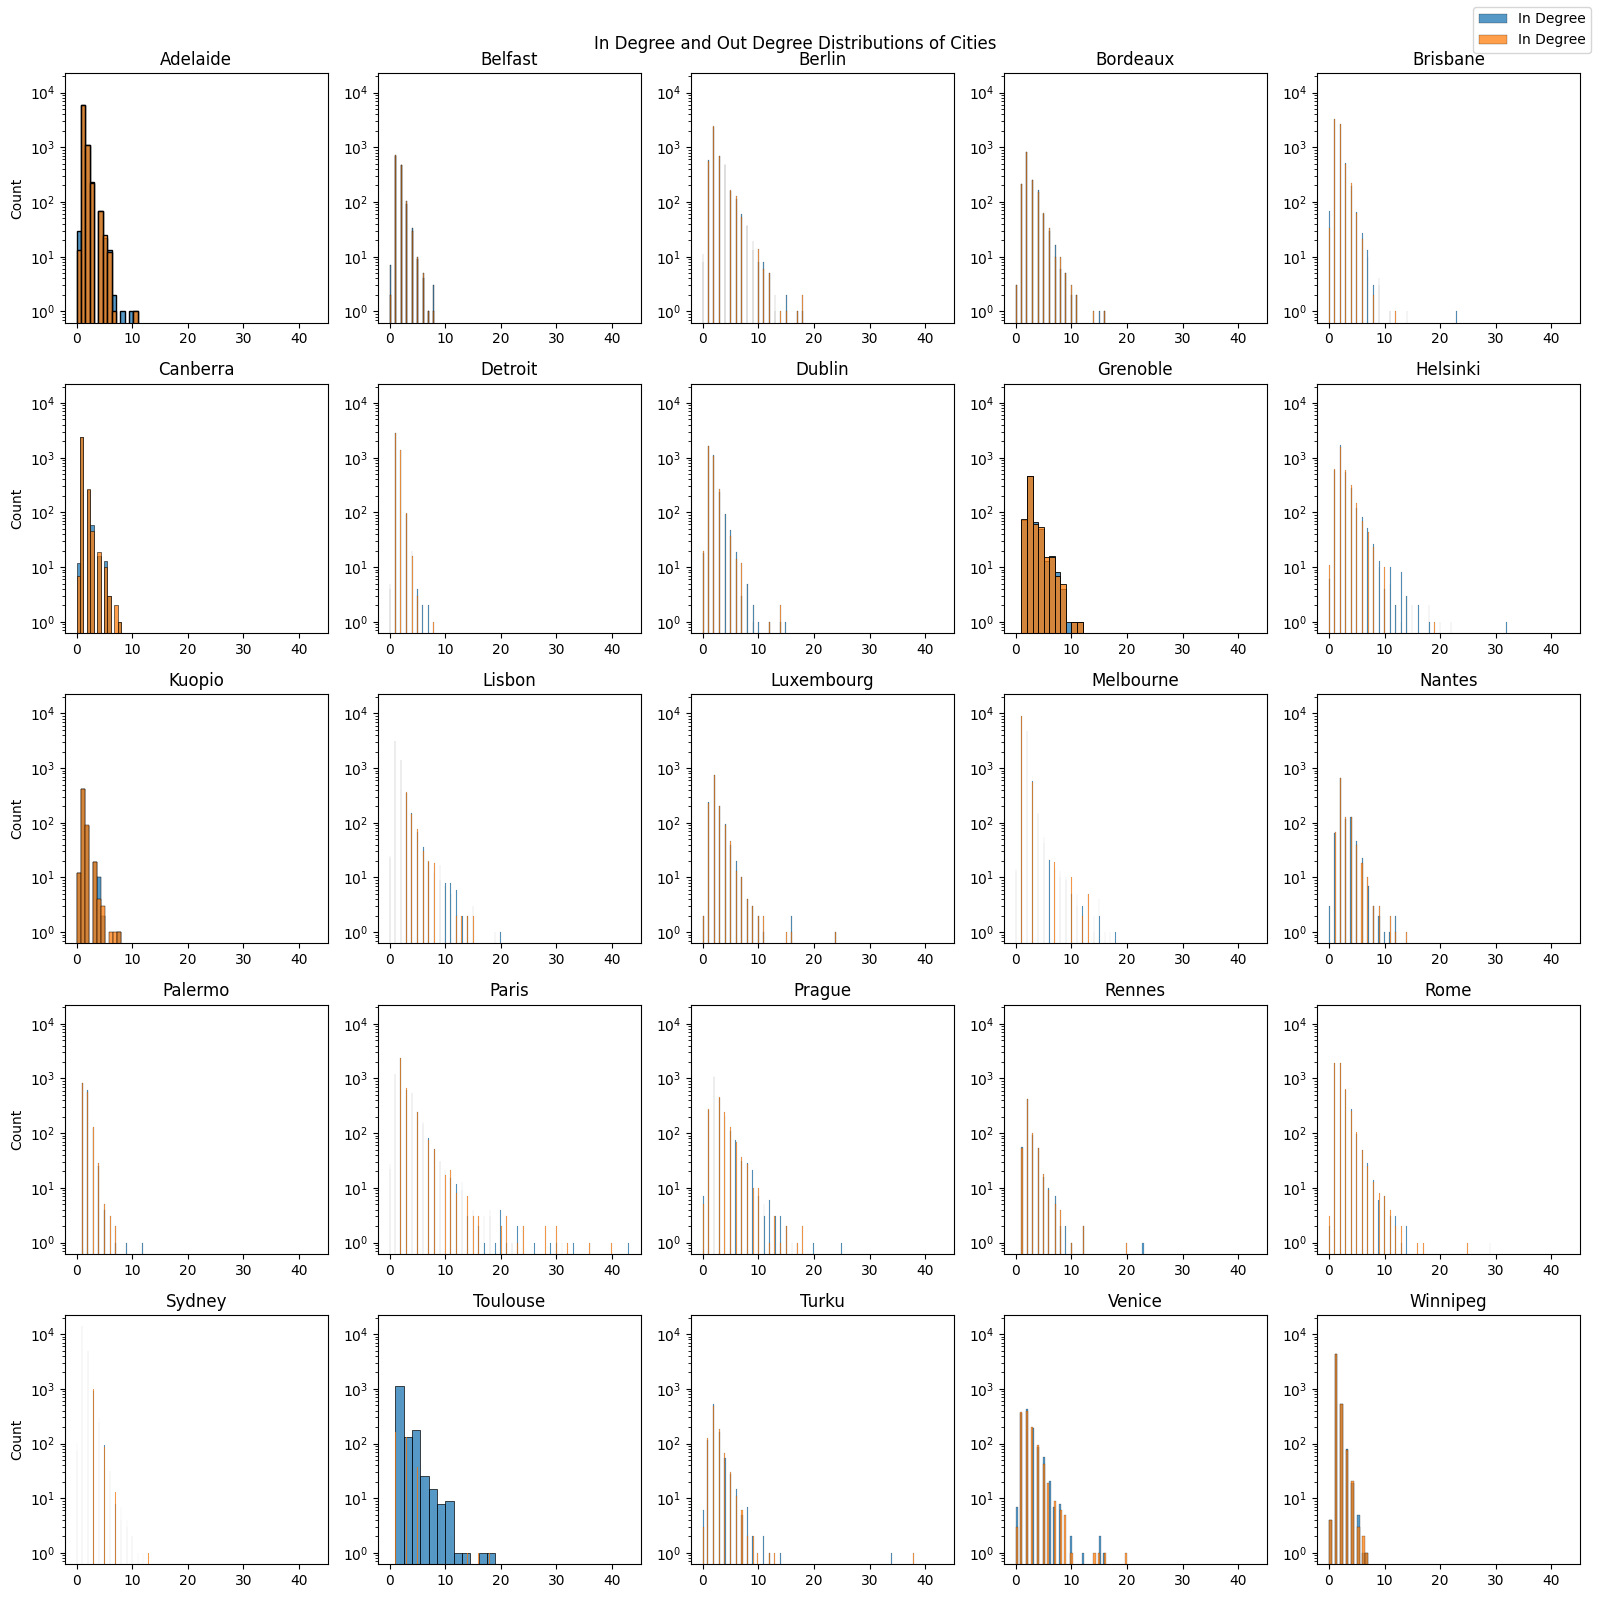

In [5]:
# Degree distribution of the transport network across different cities.

fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)

for idx, (city, city_graphs) in tqdm(enumerate(cities_graphs_dir.items())):
    city_G = city_graphs["full"]
    # Calculate the in and out degree distributions
    in_degrees = [d for n, d in city_G.in_degree()]
    out_degrees = [d for n, d in city_G.out_degree()]
    
    row = int(idx / 5)
    col = idx % 5
    
    # Plot the in degree distribution
    sns.histplot(in_degrees, ax=axes[row][col], label='In Degree')

    # Plot the out degree distribution
    sns.histplot(out_degrees, ax=axes[row][col], label='In Degree')

    axes[row][col].set_title(city.title())
    
    axes[row][col].xaxis.set_tick_params(labelbottom=True)
    axes[row][col].yaxis.set_tick_params(labelbottom=True)
    
    axes[row][col].set_yscale('log')

    
    
# Add a main title to the figure
fig.suptitle('In Degree and Out Degree Distributions of Cities')

handles, labels = axes[row][col].get_legend_handles_labels()
fig.legend(handles, labels)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

There are some cities with zero in-degree and out-degree. Next, we check number of nodes with such property.


In [6]:
city_zero_degrees = []

for city, city_graphs in tqdm(cities_graphs_dir.items()):
    city_G = city_graphs["full"]
    in_bound_zero = [city_G.nodes[node]["name"] for node in city_G.nodes if city_G.in_degree(node) == 0]
    out_bound_zero = [city_G.nodes[node]["name"] for node in city_G.nodes if city_G.out_degree(node) == 0]
    common = sum(x == y for x, y in zip(in_bound_zero, out_bound_zero))
    
    city_zero_degrees.append([city.title(), len(in_bound_zero), len(out_bound_zero), common])
    
city_zero_degrees_df = pd.DataFrame(city_zero_degrees, columns=["City", "Zero in-deg count", "Zero out-deg count", "Common"])
city_zero_degrees_df

100%|████████████████████████████████████████████| 25/25 [00:00<00:00, 226.45it/s]


,City,Zero in-deg count,Zero out-deg count,Common
0,Adelaide,30,13,0
1,Belfast,7,2,0
2,Berlin,8,11,0
3,Bordeaux,3,3,0
4,Brisbane,68,33,0
5,Canberra,12,7,0
6,Detroit,5,4,0
7,Dublin,18,20,0
8,Grenoble,0,0,0
9,Helsinki,6,11,0


Out of 25 cities, only 4 cities have nodes with non zero degrees and rest of them have few to many nodes with zero in/out degree. Preliminary examination shows that the stops on the opposite side of the road have different name and hence they are treated as different nodes. Although, we merged the nodes with same name into a single one, we do not clean the nodes with zero degree. We assume that they are different nodes and continue the analysis.


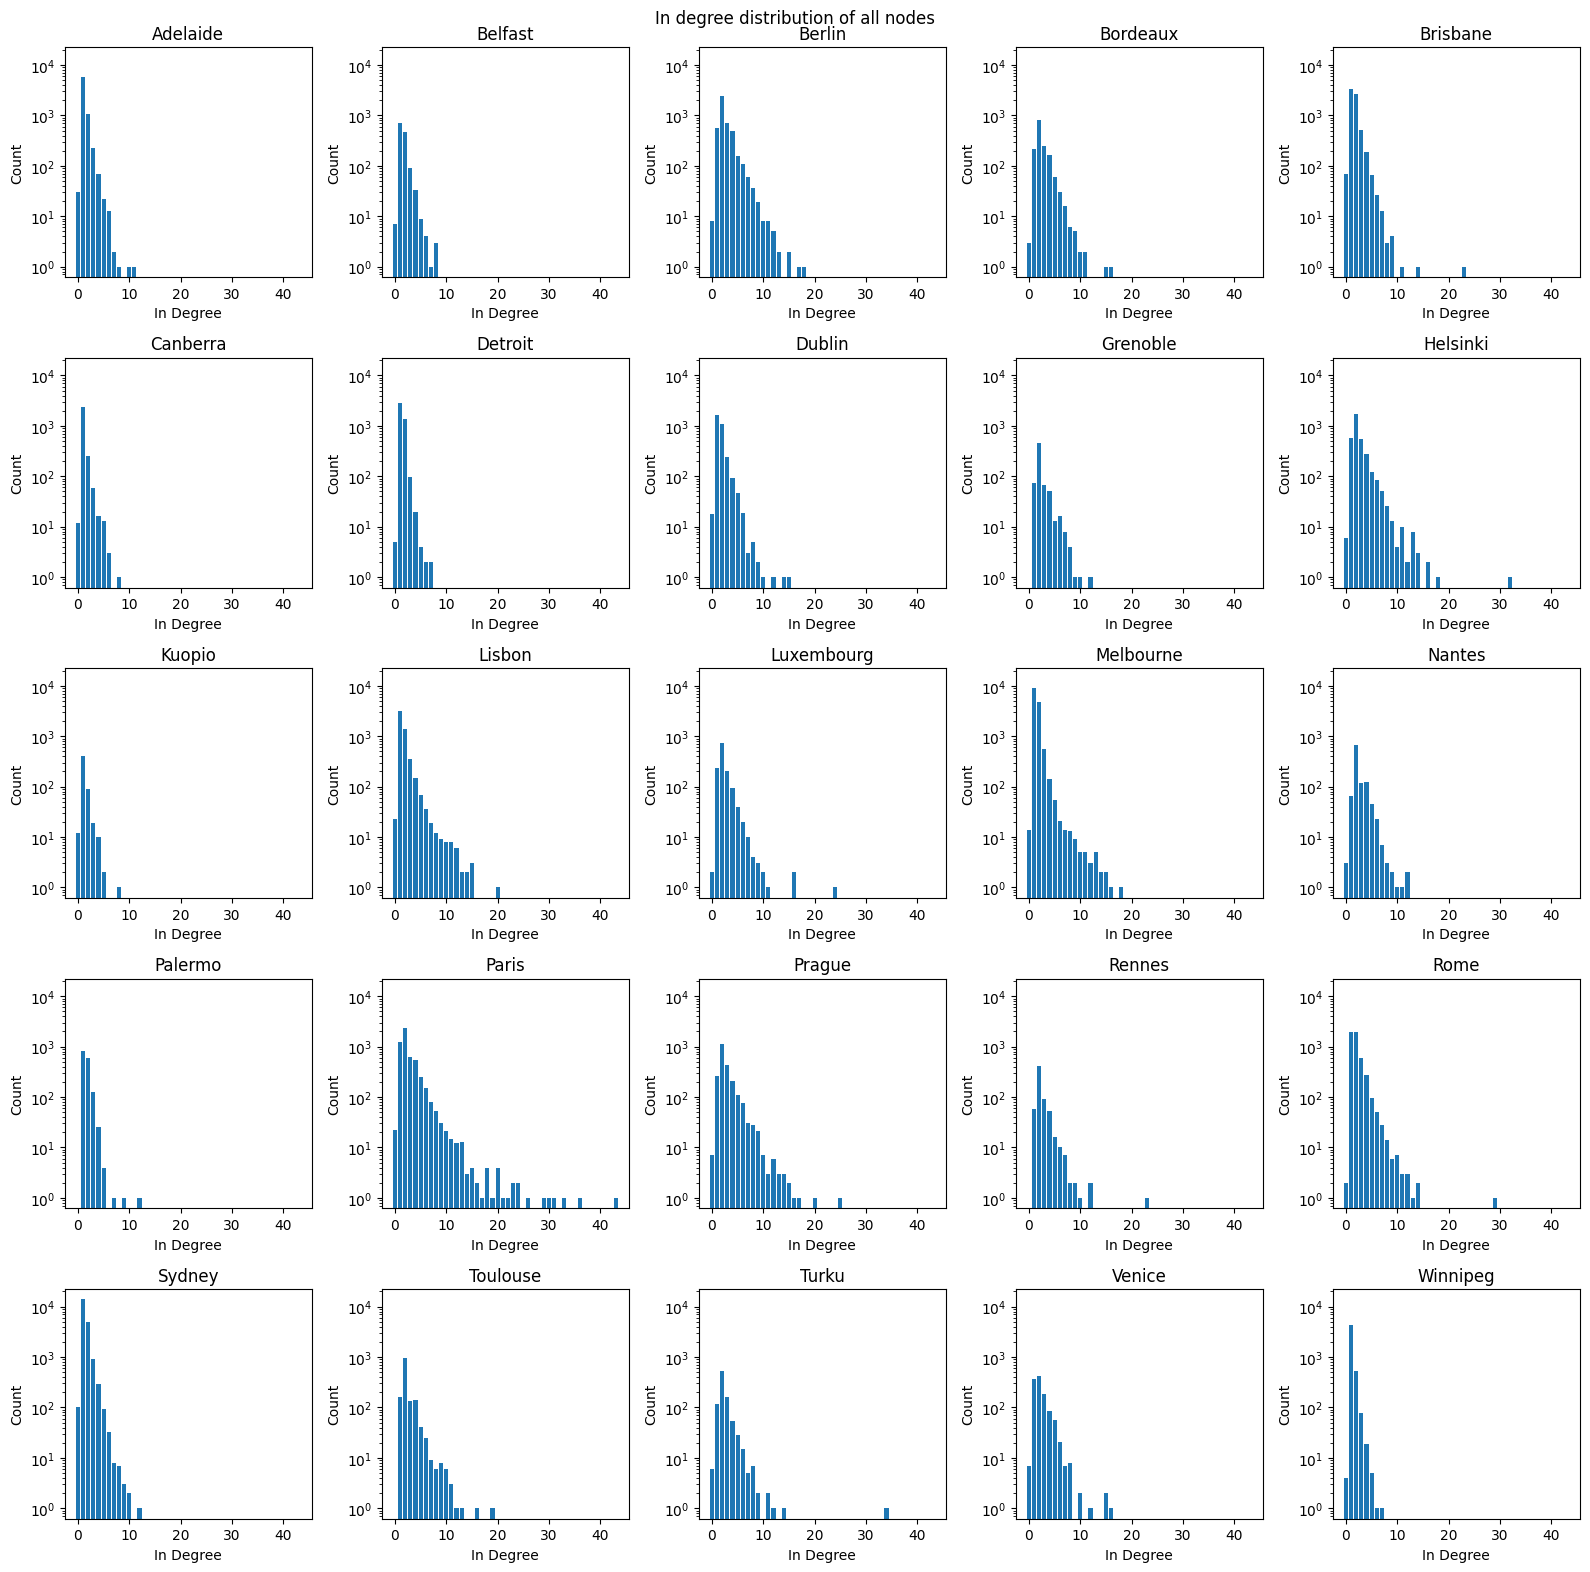

In [7]:
# In-Degree distribution of the transport network across different cities.

fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)
for idx, (city, city_graphs) in enumerate(cities_graphs_dir.items()):
    city_G = city_graphs["full"]
    in_degree_sequence = sorted([d for n, d in city_G.in_degree()], reverse=True)
    in_degreeCount = collections.Counter(in_degree_sequence)
    in_deg, in_count = zip(*in_degreeCount.items())

    # Plot the distribution as a bar graph
    row = int(idx / 5)
    col = idx % 5
    
    inbars = axes[row][col].bar(in_deg, in_count)
    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("In Degree")
    axes[row][col].set_yscale('log')
    # axes[row][col].bar_label(inbars)
    axes[row][col].xaxis.set_tick_params(labelbottom=True)
    axes[row][col].yaxis.set_tick_params(labelbottom=True)
    
fig.suptitle('In degree distribution of all nodes')    
fig.tight_layout()

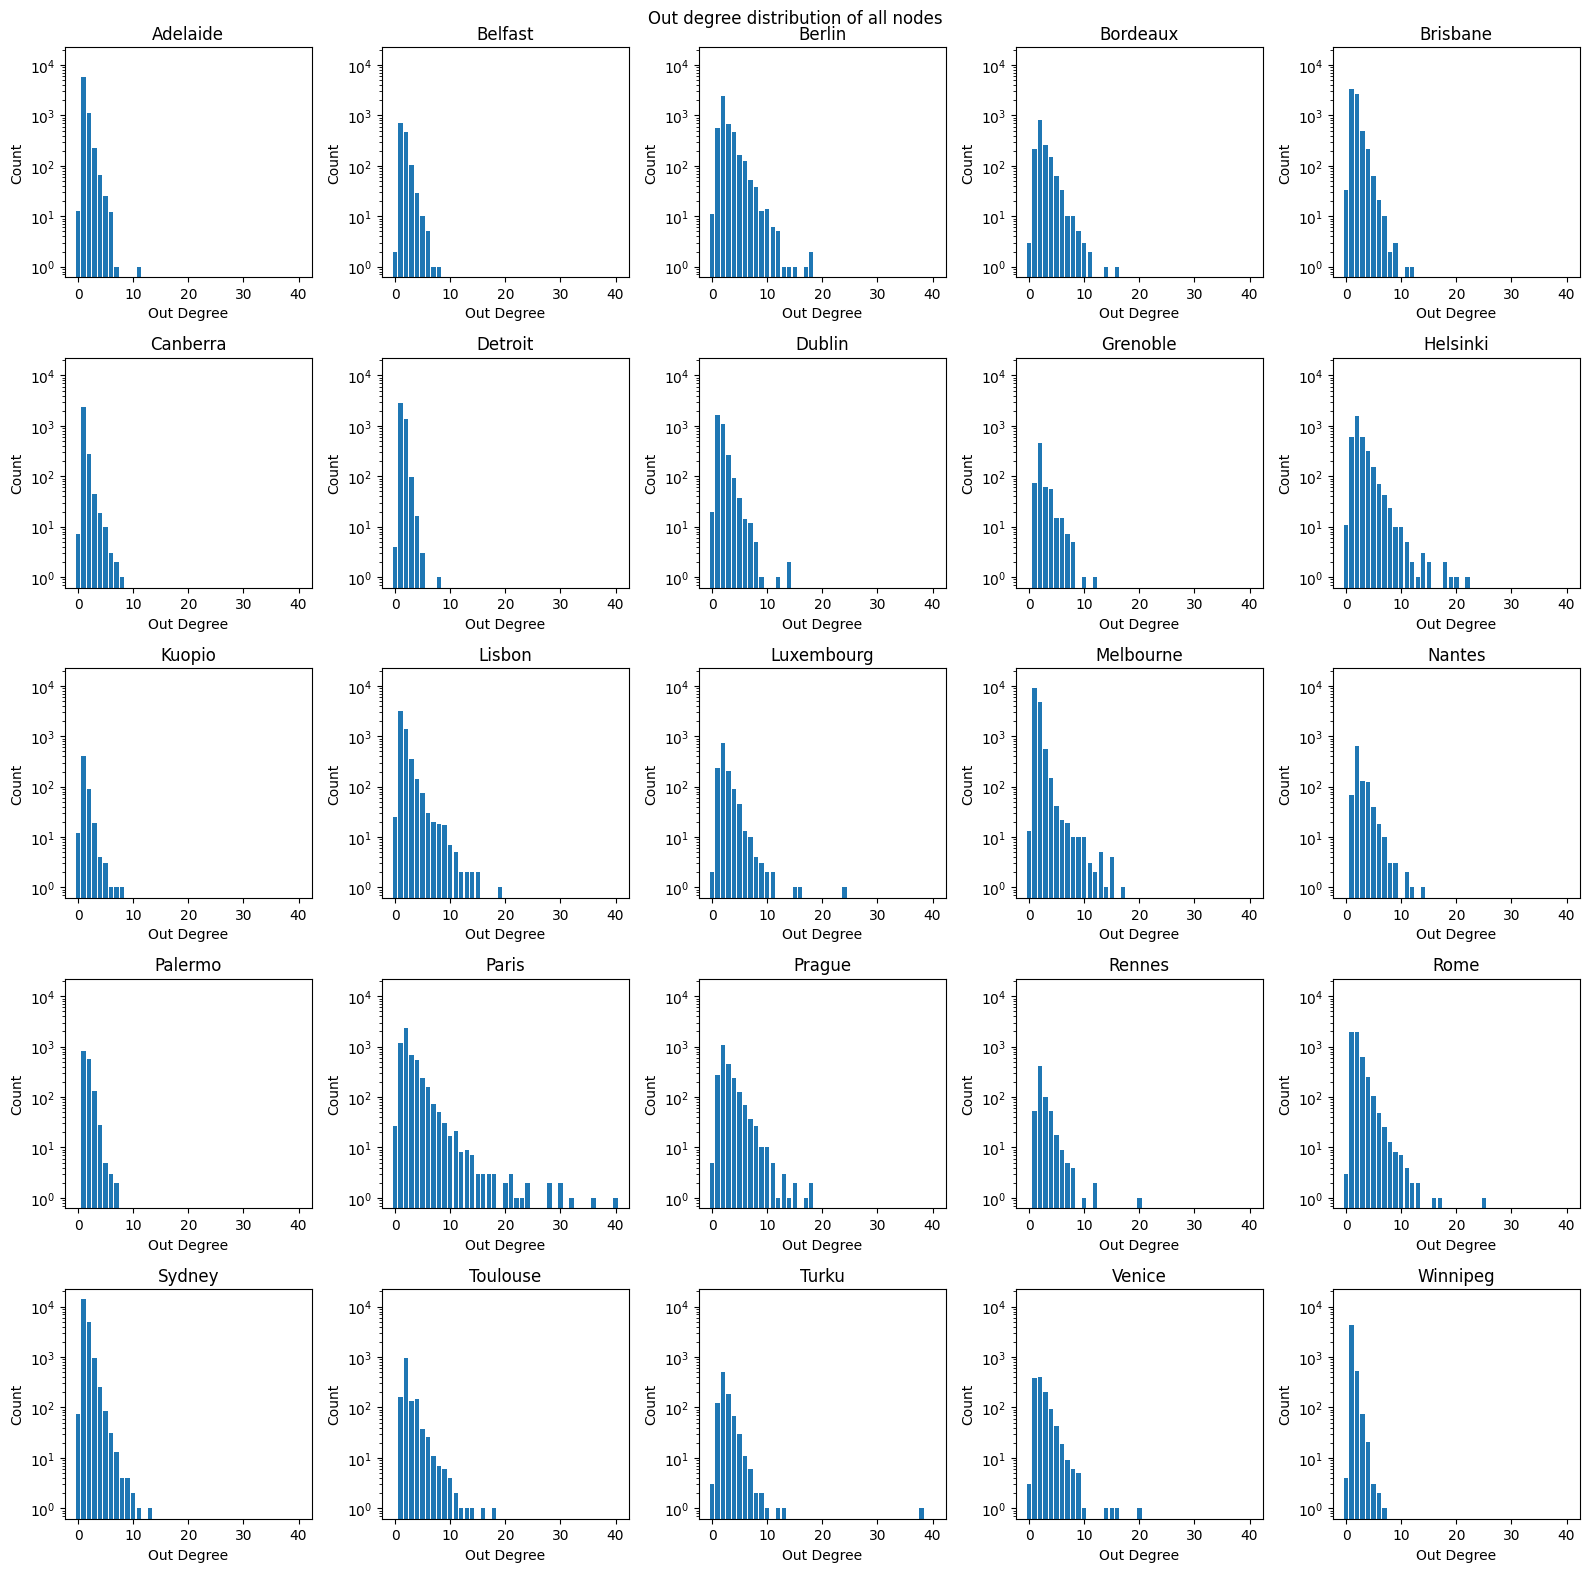

In [8]:
# Out-Degree distribution of the transport network across different cities.

fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)
for idx, (city, city_graphs) in enumerate(cities_graphs_dir.items()):
    city_G = city_graphs["full"]
    out_degree_sequence = sorted([d for n, d in city_G.out_degree()], reverse=True)
    out_degree_count = collections.Counter(out_degree_sequence)
    out_deg, out_count = zip(*out_degree_count.items())

    # Plot the distribution as a bar graph
    row = int(idx / 5)
    col = idx % 5

    inbars = axes[row][col].bar(out_deg, out_count)
    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("Out Degree")
    axes[row][col].set_yscale('log')
    # axes[row][col].bar_label(inbars)
    axes[row][col].xaxis.set_tick_params(labelbottom=True)
    axes[row][col].yaxis.set_tick_params(labelbottom=True)
    
fig.suptitle('Out degree distribution of all nodes')
fig.tight_layout()

In the above two plots, we observe that for all the cities in the dataset the in-degree distribution follows a very similar pattern to the out-degree distribution of graph nodes.
This degree distribution captures connections between two places in a city through any type of public transportation that is available in the city.

### Network properties

In the degree distribution of the city networks, the existence of a large number of nodes with low degrees and a smaller number of nodes with higher degrees is observed. This implies that the above networks cannot be modelled by a random network model.


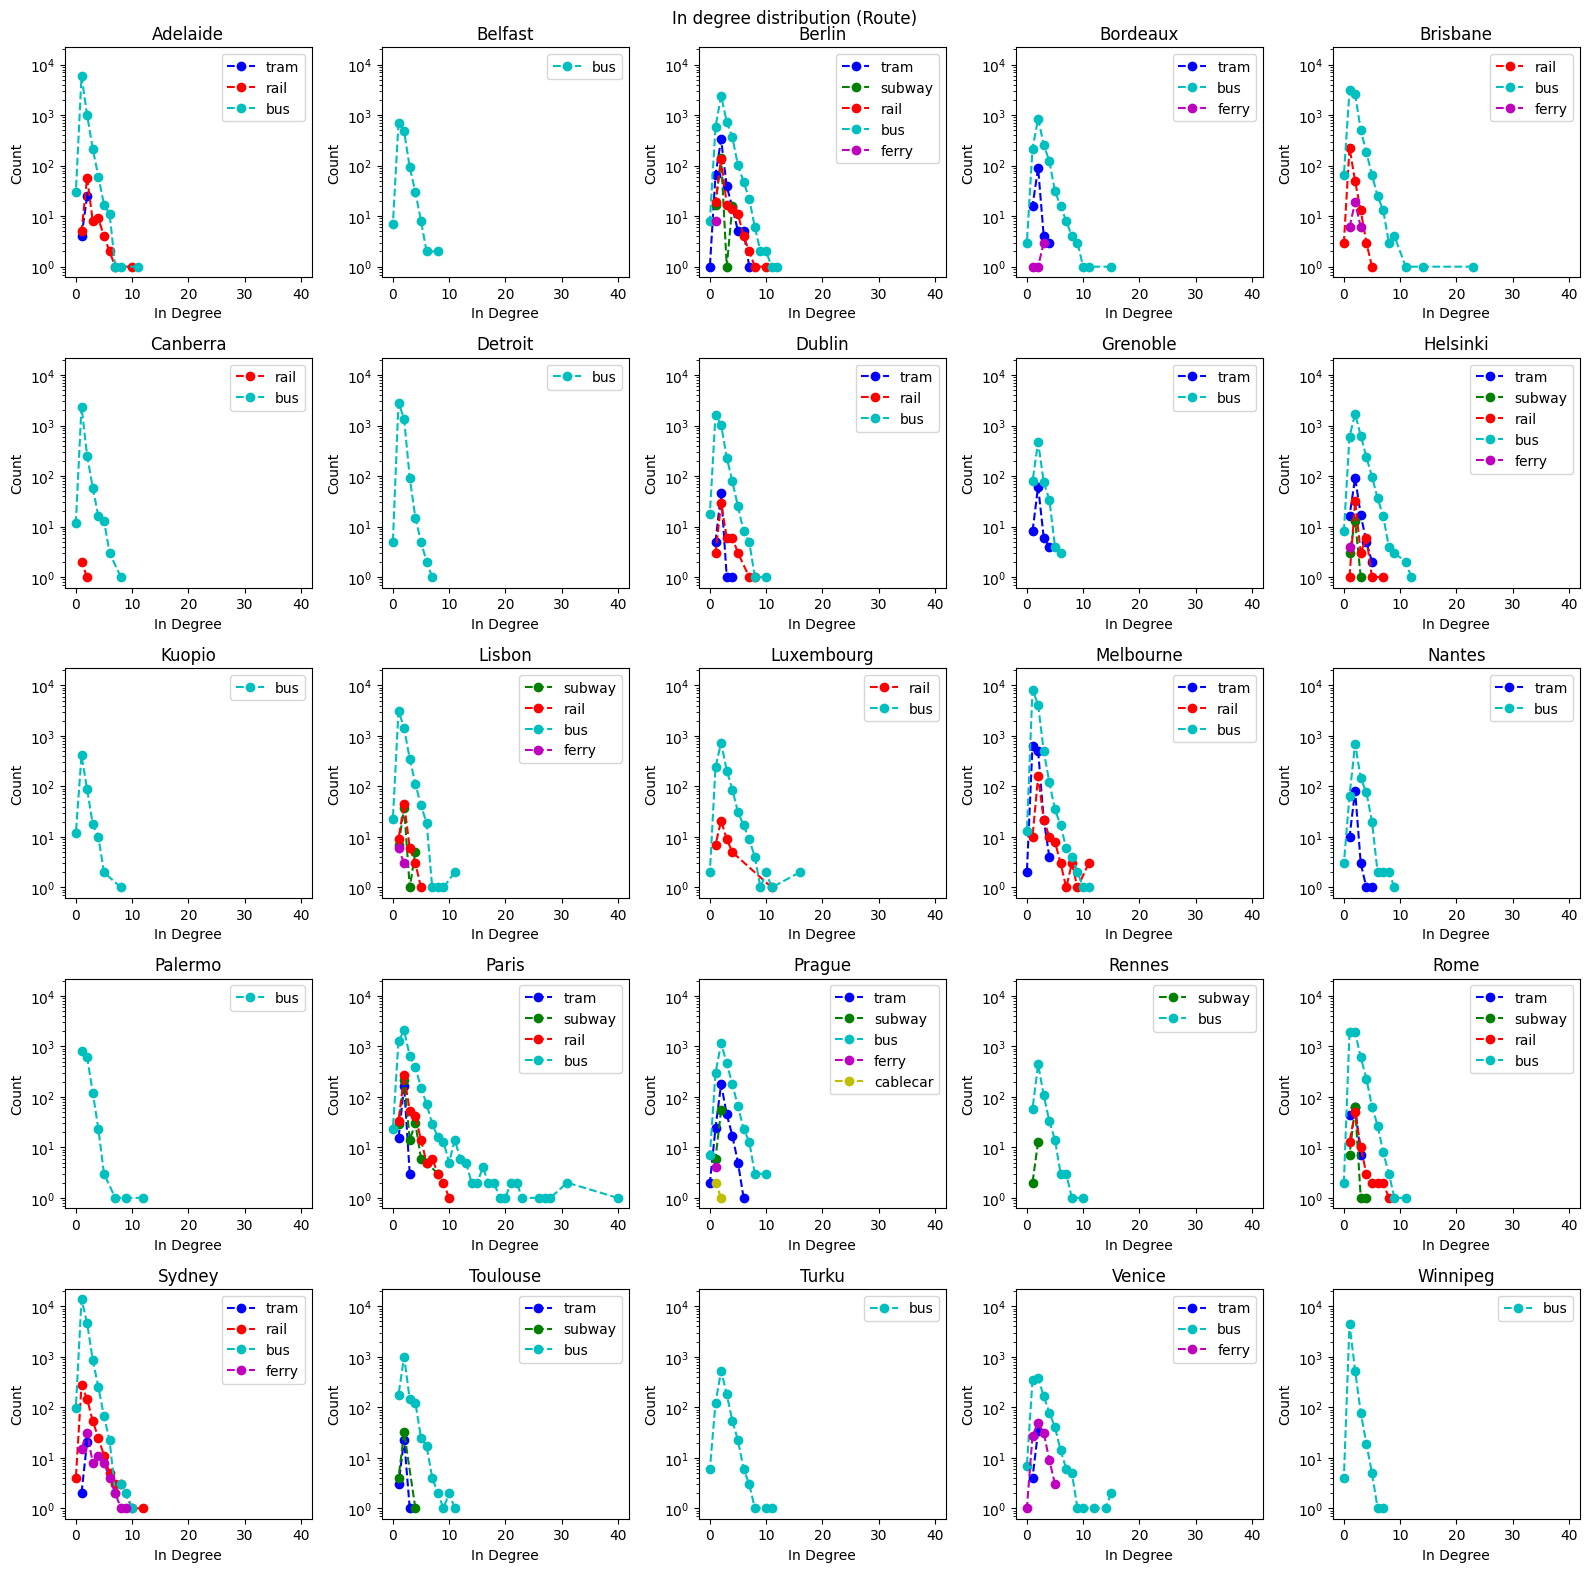

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)
for idx, (city, city_graphs) in enumerate(cities_graphs_dir.items()):

    # Split the degree plots into a 2-d grid
    row = int(idx / 5)
    col = idx % 5

    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("In Degree")
    
    for route_idx, (route_label, route_subgraph) in enumerate(city_graphs.items()):
        
        # ignore the complete transport graph of the city
        if ((route_label == "full") or (route_subgraph is None)):
            continue

        in_degree_sequence = sorted([d for n, d in route_subgraph.in_degree()], reverse=True)
        in_degreeCount = collections.Counter(in_degree_sequence)
        in_deg, in_count = zip(*in_degreeCount.items())

        # Plot the degree distribution as a line graph
        axes[row][col].plot(in_deg, in_count, color=mcolors[route_idx], label=route_label, linestyle='--', marker='o')
        
        axes[row][col].set_yscale('log')
        axes[row][col].xaxis.set_tick_params(labelbottom=True)
        axes[row][col].yaxis.set_tick_params(labelbottom=True)

    axes[row][col].legend()
    
fig.suptitle('In degree distribution (Route)')
fig.tight_layout()

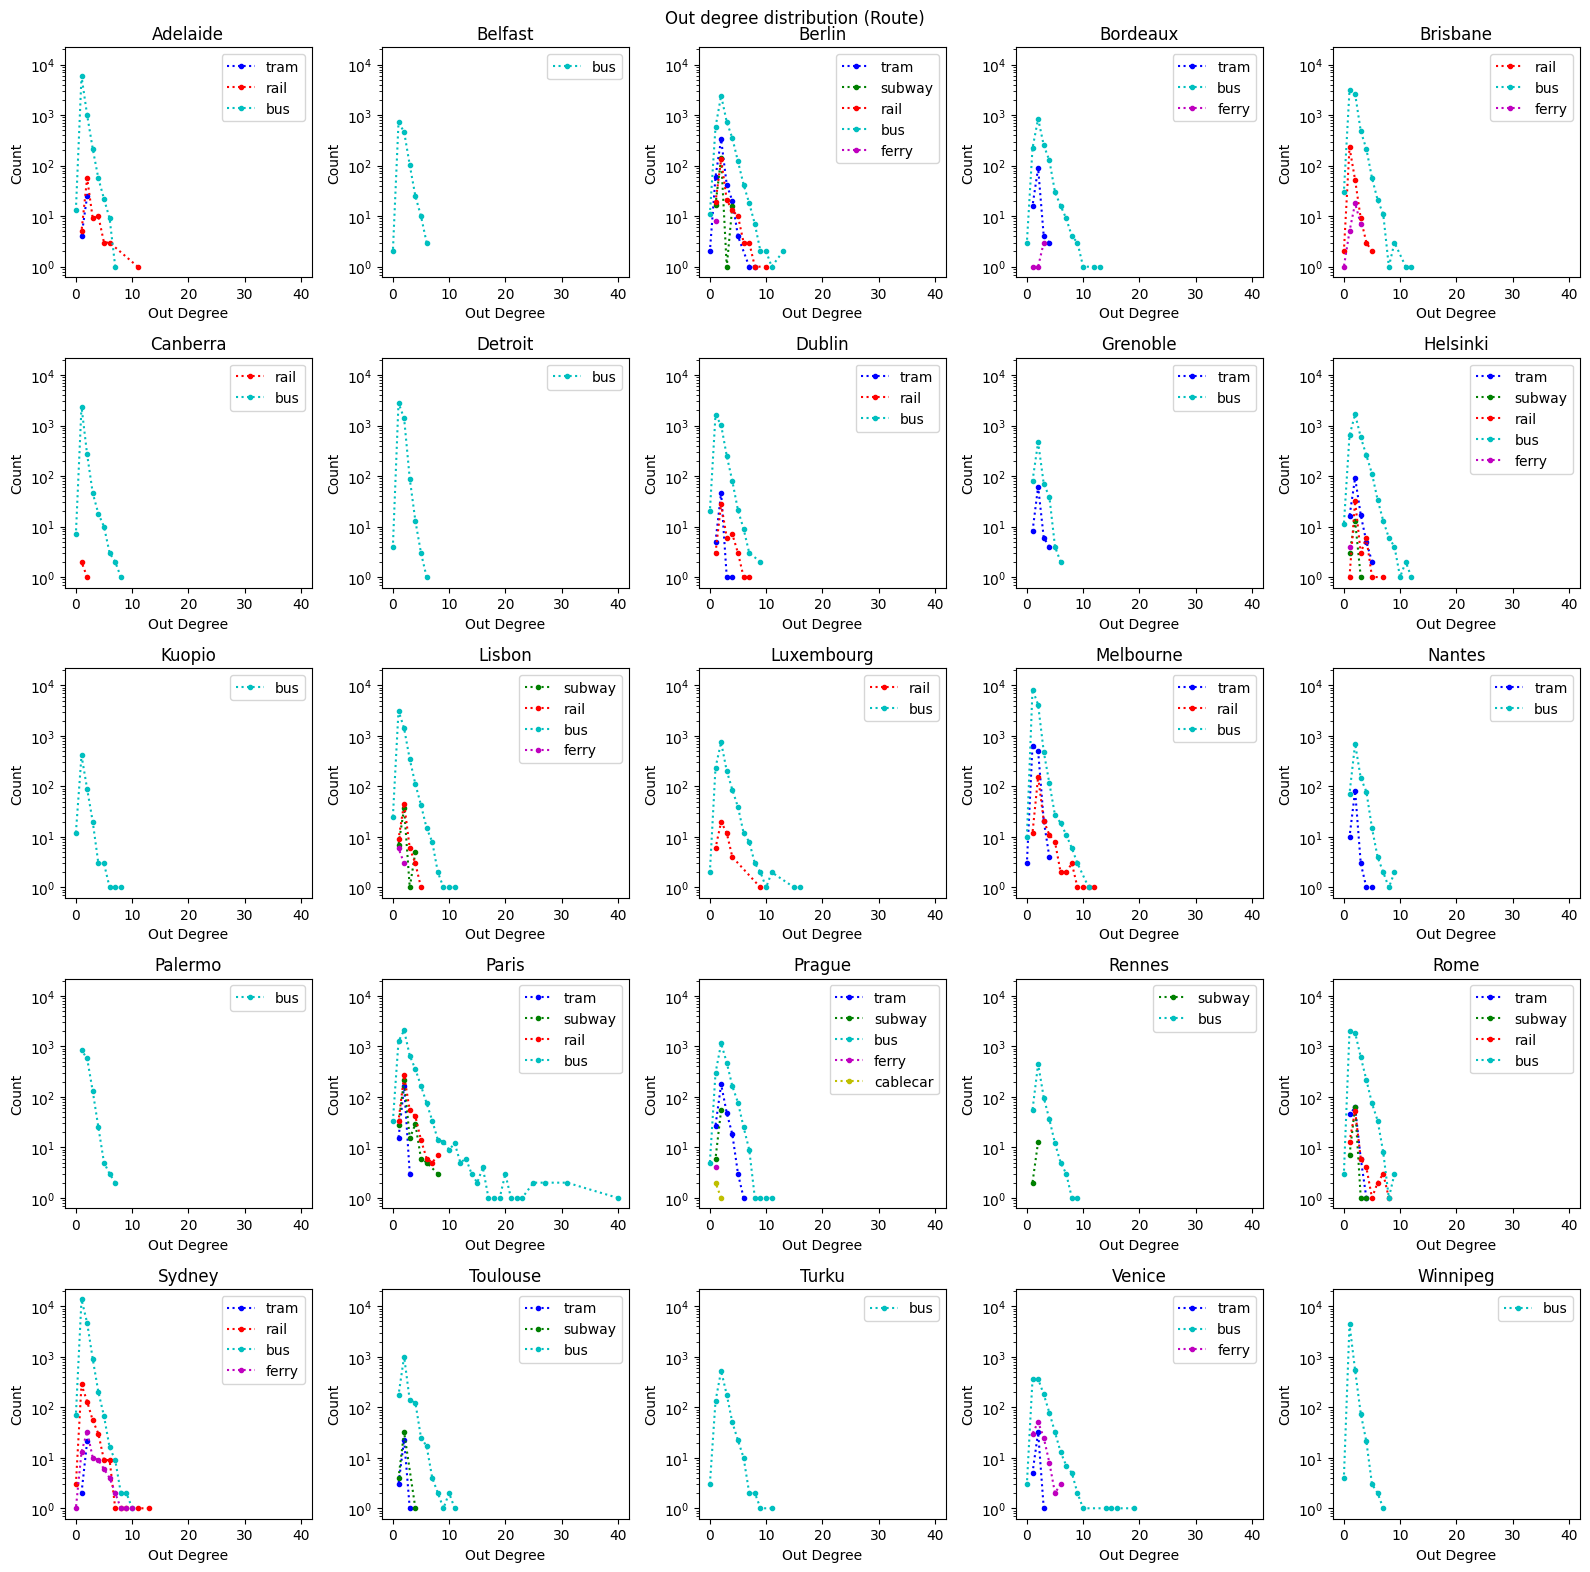

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)
for idx, (city, city_graphs) in enumerate(cities_graphs_dir.items()):

    # Split the degree plots into a 2-d grid
    row = int(idx / 5)
    col = idx % 5

    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("Out Degree")
    
    for route_idx, (route_label, route_subgraph) in enumerate(city_graphs.items()):
        
        # ignore the complete transport graph of the city
        if ((route_label == "full") or (route_subgraph is None)):
            continue

        out_degree_sequence = sorted([d for n, d in route_subgraph.out_degree()], reverse=True)
        out_degreeCount = collections.Counter(out_degree_sequence)
        out_deg, out_count = zip(*out_degreeCount.items())

        # Plot the degree distribution as a line graph
        axes[row][col].plot(out_deg, out_count, color=mcolors[route_idx], label=route_label, linestyle=':', marker='.')
        
        axes[row][col].set_yscale('log')
        axes[row][col].xaxis.set_tick_params(labelbottom=True)
        axes[row][col].yaxis.set_tick_params(labelbottom=True)

    axes[row][col].legend()
    
fig.suptitle('Out degree distribution (Route)')
fig.tight_layout()

In the above two plots, we observe that for all the cities in the dataset the in-degree distribution follows a very similar pattern to the out-degree distribution of graph nodes, even when the same mode of transport is considered. As a result, it would be safe to assume either the in-degree or the out-degree of the nodes in transport network of any city as the degree of the node in our network. We would hence be considering the dataset graph to be an unirected graph with either of the in-degrees or out-degrees of the original graph as the equivalent undirected graph's degree, for further analysis from here onwards.

It also implies that in these transport networks, the most types of public transportation listed in the dataset provide a two-way connectivity between any two places in the city.


In [11]:
# Create a list to store metrics for each city
city_metrics_list_dir = []

# Loop over cities and load their graphs, then calculate metrics and add them to the list
for city, city_graphs in tqdm(cities_graphs_dir.items()):
    for route_type, route_graph in city_graphs.items():
            
        if ((route_graph is not None) and (route_type not in ["cablecar", "full"])):
            # Calculate city metrics
            city_metrics = calculate_city_metrics(city, route_type, route_graph)

            # Add city metrics to the list
            city_metrics_list_dir.append(city_metrics)

# Create a dataframe with the metrics for all cities
city_metrics_dir_df = pd.DataFrame(city_metrics_list_dir)

# Print the dataframe
city_metrics_dir_df

100%|█████████████████████████████████████████████| 25/25 [00:02<00:00,  8.38it/s]


,city,route,num_nodes,num_edges,avg_degree,median_duration,diameter,density,top_in_degree_nodes,bottom_in_degree_nodes,top_out_degree_nodes,bottom_out_degree_nodes
0,adelaide,tram,29,54,1.862069,1.701604,28.0,0.066502,"[(Stop 12 Morphett Rd, 2)]","[(Stop Tram Entertainment Centre, 1)]","[(Stop 12 Morphett Rd, 2)]","[(Stop Tram Entertainment Centre, 1)]"
1,adelaide,rail,88,230,2.613636,2.000000,28.0,0.030042,"[(Adelaide Railway Station, 10)]","[(Gawler Central Railway Station, 1)]","[(Adelaide Railway Station, 11)]","[(Gawler Central Railway Station, 1)]"
2,adelaide,bus,7215,8952,1.240748,0.866667,inf,0.000172,"[(Stop 24 Crafers Ramp - South side, 11)]","[(Stop 16/21D Jetty Rd - South side, 1)]","[(Stop 49 Church St - West side, 7)]","[(Stop 16/21D Jetty Rd - South side, 1)]"
3,belfast,bus,1327,2128,1.603617,1.000000,inf,0.001209,"[(Donegall Park Avenue, 8)]","[(Mount Eagles, 1)]","[(Templemore Avenue, 6)]","[(Mount Eagles, 1)]"
4,berlin,tram,462,965,2.088745,1.000000,inf,0.004531,"[(Schönhauser Allee/Bornholmer Str. (Berlin), 7)]","[(Lesser-Ury-Weg (Berlin), 1)]","[(Siegfriedstr./Josef-Orlopp-Str. (Berlin), 8)]","[(Freiheit (Berlin), 1)]"
...,...,...,...,...,...,...,...,...,...,...,...,...
62,turku,bus,927,2137,2.305286,0.739796,inf,0.002490,"[(Vähäheikkiläntie, 11)]","[(Leipäläntie, 1)]","[(Vähäheikkiläntie, 11)]","[(Leipäläntie, 1)]"
63,venice,tram,38,72,1.894737,1.000000,27.0,0.051209,"[(La Piazza, 2)]","[(Favaro, 1)]","[(Olivi, 3)]","[(Favaro, 1)]"
64,venice,bus,1044,2354,2.254789,1.000000,inf,0.002162,"[(Cimitero, 15)]","[(Mira Scuole Civ.16, 1)]","[(Cimitero, 19)]","[(Mira Scuole Civ.16, 1)]"
65,venice,ferry,119,267,2.243697,5.000000,inf,0.019014,"[(Zattere SX, 5)]","[(Zitelle DX, 1)]","[(Zattere SX, 6)]","[(F.te Nove ""A"", 1)]"


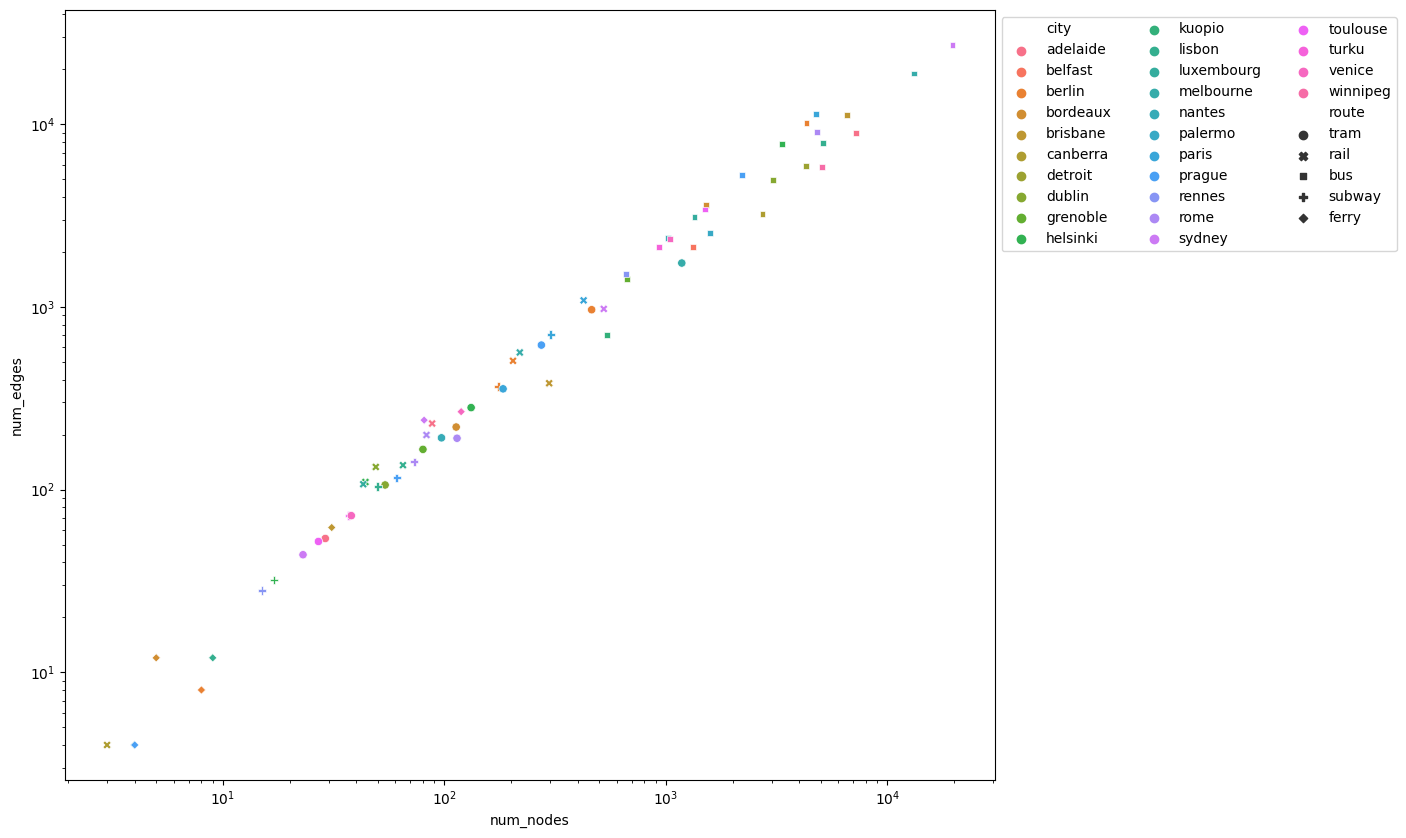

In [14]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=city_metrics_dir_df, x="num_nodes", y="num_edges", style="route", hue="city")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=3)
plt.xscale('log')
plt.yscale('log')

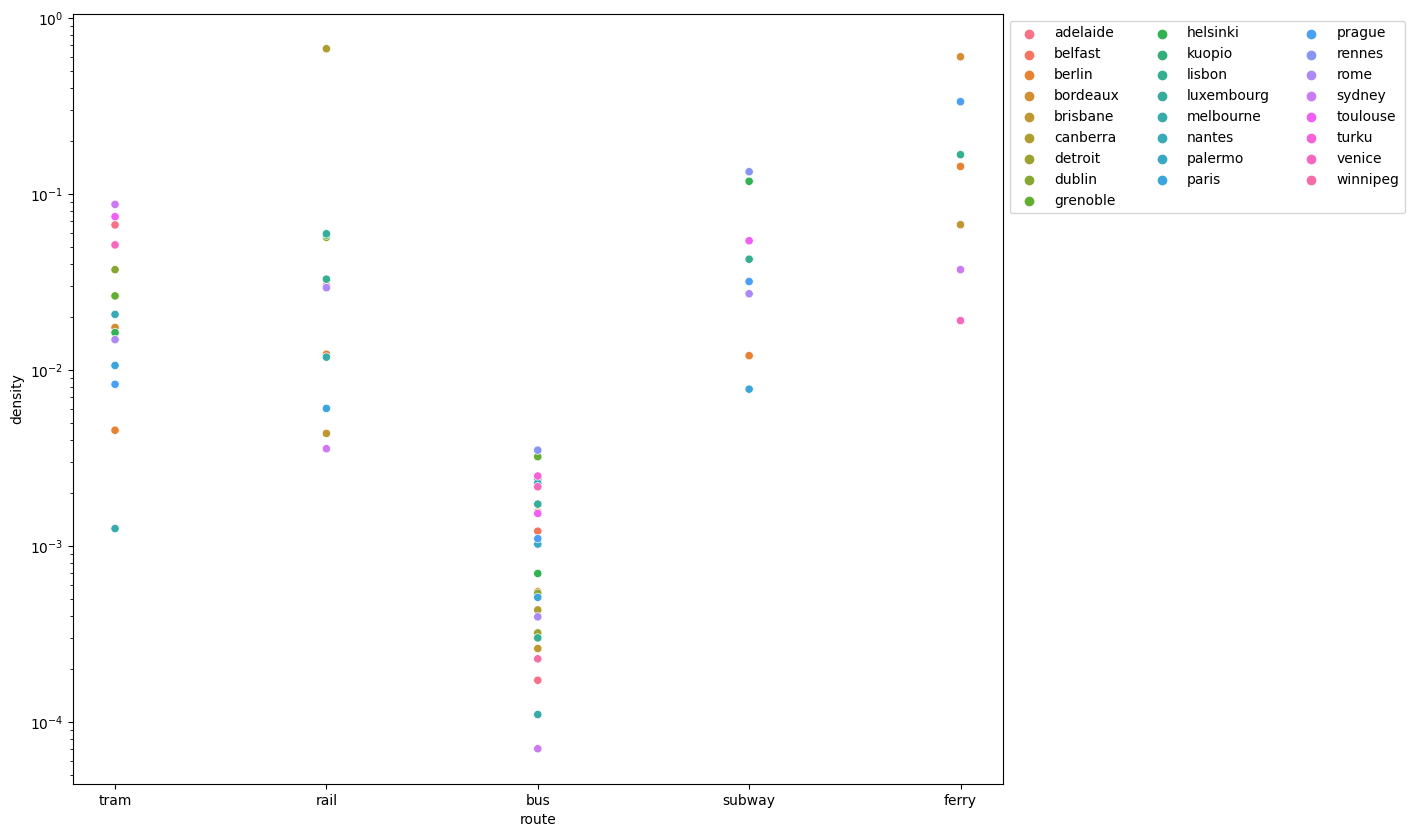

In [15]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=city_metrics_dir_df, x="route", y="density", hue="city")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=3)
plt.yscale('log')

<Figure size 1600x1600 with 0 Axes>

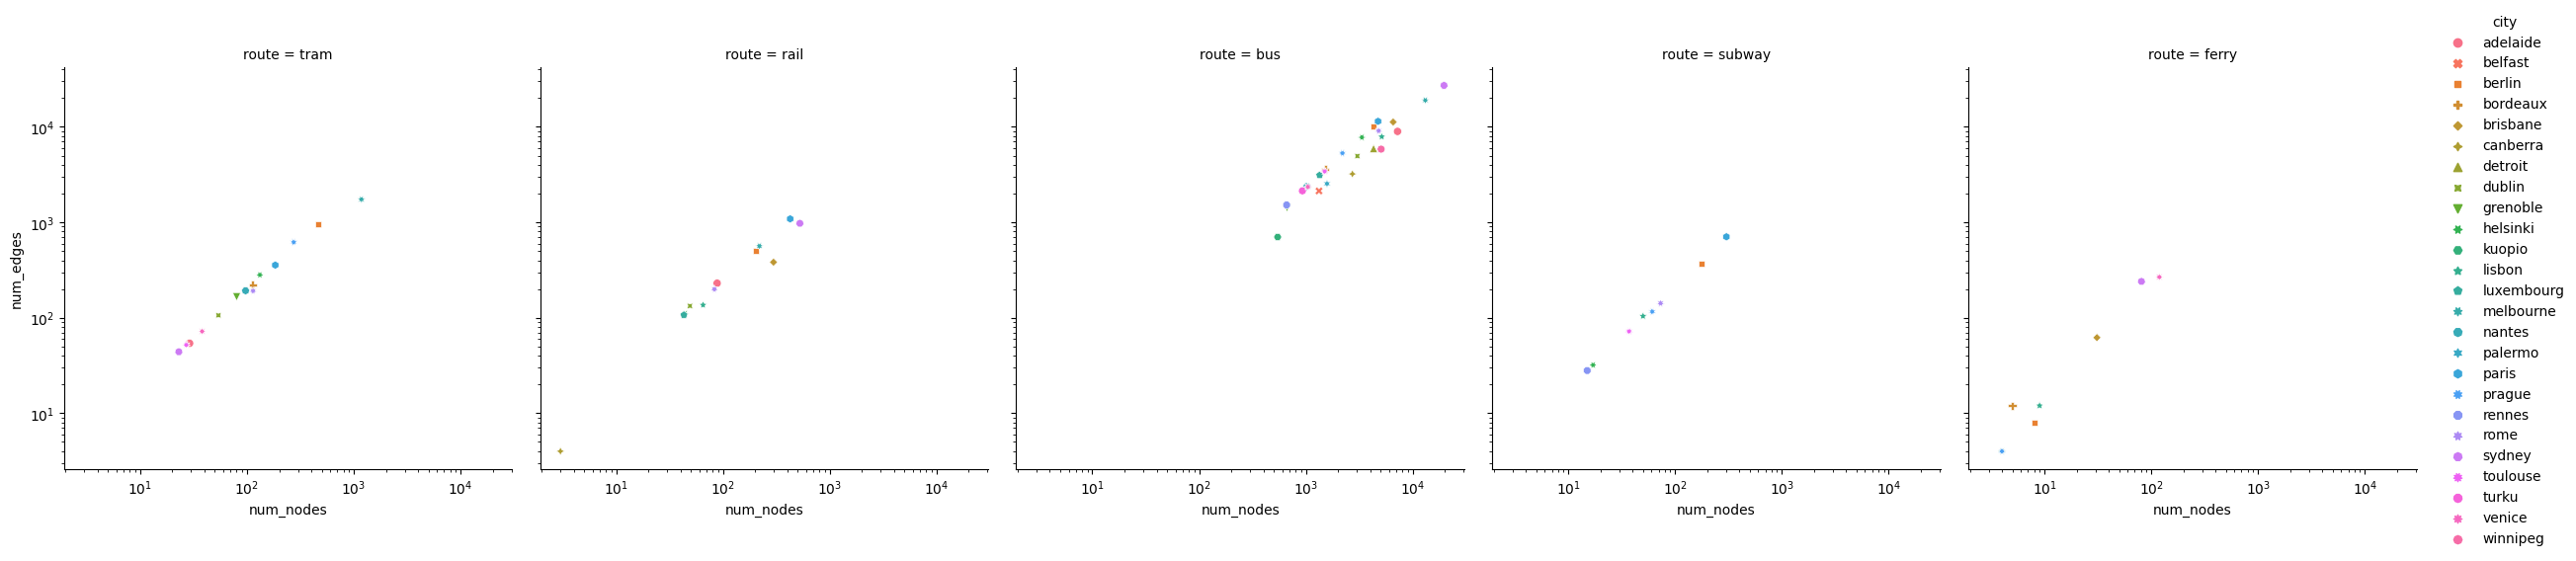

In [16]:
plt.figure(figsize=(16,16))
sns.relplot(
    data=city_metrics_dir_df, x="num_nodes", y="num_edges",
    col="route", style="city", hue="city",
    kind="scatter",
)
plt.xscale('log')
plt.yscale('log')

### Node and Degree Distribution

The above table shows, for each city, the number of nodes, edges, nodes with highest/lowest in/out-degree. For the nodes with lowest degree, we ignore those nodes with 0 degree. While this table does not give the information on density of connection i.e. number of services serving a stop, it tell us about the connectivity and nodes that connected. While looking a individual route type can inform us more the well connected station for that mode of transport, this gives us a highly view of the connectivity. Lastly, the average degree has a median of 2.03 and mean of 2.0 telling us that each station is connected with two other stations.

### Median Travel time

The average travel time between two stops is provided for each route type between the nodes and here we check the median value over all edges for each route type (in minutes). All the cities have around 1 minute of median travel time in full network except Detroit and Winnipeg, where it is half a minutes and Paris and Prague, where it is nearly 2 minutes. However, on individual transport mode level, people in Paris, Toulouse and Grenoble spend 2 minutes on average on tram and other spend around a minute to minute and a half. For the subways, Helsinki has the highest time of 1.9 minutes. For the rail, people in Canberra spend 20 minutes which is followed by distantly second Luxembourg at 3.87 minutes. Buses are the only mode present in all the cities and their average travel time between the stops is one minute. Only 8 cities have the ferry system and the average travel time between the ferry stops is highest in Bordeaux (9.5 minutes) followed by Sydney (8.9 minutes) while it is only 2 minutes in Prague. Lastly, only Prague has a cablecar with three nodes and a average duration of 1.5 minutes between the stops.

### Betweenness centrality

The betweenness centrality of the nodes is calculated using the average duration between stops. It captures the relative importance of transfer nodes within the network.


In [ ]:
########################################################################################################
                # Uncomment to run this again, it's a computationally expensive operation.
                # The betweenness centrality values are calculated and dumped into the folder
                # data/checkpoints/
########################################################################################################

# city_network_graphs_dir_betweenness.mkdir(parents=True, exist_ok=True)

# for city_name, city_graphs in tqdm(cities_graphs_dir.items()):
#     print("[DEBUG] Calculating betweenness centrality for city {}".format(city_name))
#     for route_type, route_graph in city_graphs.items():
#         if route_graph is not None:
#             betweenness = nx.betweenness_centrality(route_graph, weight='duration_avg')
#             # Assign the computed centrality values as a node-attribute 
#             nx.set_node_attributes(route_graph, betweenness, 'betweenness')
   
#     with open(city_network_graphs_dir_betweenness.joinpath(city_name + '.gpickle'), 'wb') as f:
#         pickle.dump(city_graphs, f, pickle.HIGHEST_PROTOCOL)

In [17]:
cities = sorted([x.stem for x in city_network_graphs_dir_betweenness.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir_betweenness)

In [18]:
for city_name, city_graphs in tqdm(cities_graphs_dir.items()):
    print("\n\nFor {} City".format(city_name))
    for route_type, route_graph in city_graphs.items():
        if route_graph is not None:
            print("\tin {} route".format(route_type))
            betweenness = nx.get_node_attributes(route_graph, "betweenness")
            sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)
            for node, bw in sorted_betweenness[:2]:
                print("\t\t", route_graph.nodes[node]['name'], 'betweeness: %.3f' %bw, 'in-deg %d' %route_graph.in_degree(node), 'out-deg %d' %route_graph.out_degree(node))

100%|████████████████████████████████████████████| 25/25 [00:00<00:00, 252.93it/s]



For adelaide City
	in tram route
		 Stop 4 Forestville betweeness: 0.519 in-deg 2 out-deg 2
		 Stop 5 Black Forest betweeness: 0.516 in-deg 2 out-deg 2
	in rail route
		 Adelaide Railway Station betweeness: 0.662 in-deg 10 out-deg 11
		 Woodville Railway Station betweeness: 0.370 in-deg 4 out-deg 4
	in bus route
		 Stop 26 Main South Rd - North West side betweeness: 0.134 in-deg 2 out-deg 2
		 Stop 27 Main South Rd - North West side betweeness: 0.124 in-deg 5 out-deg 4
	in full route
		 Stop 26 Main South Rd - North West side betweeness: 0.130 in-deg 2 out-deg 2
		 Stop 27 Main South Rd - North West side betweeness: 0.121 in-deg 5 out-deg 4


For belfast City
	in bus route
		 Royal Avenue (Castle Court) betweeness: 0.291 in-deg 8 out-deg 5
		 Interpoint betweeness: 0.251 in-deg 3 out-deg 5
	in full route
		 Royal Avenue (Castle Court) betweeness: 0.300 in-deg 8 out-deg 8
		 Interpoint betweeness: 0.257 in-deg 3 out-deg 5


For berlin City
	in tram route
		 Wilhelminenhofstr./Edisonst

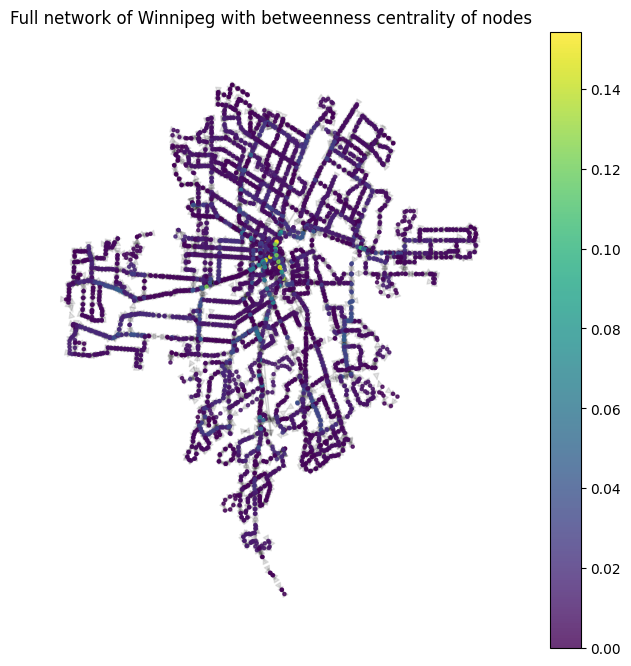

In [19]:
plt.subplots(figsize=(8, 8))
city_network = cities_graphs_dir["winnipeg"]["full"]

list_nodes =list(city_network.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 

pos = {}
node_lons = nx.get_node_attributes(city_network, "lon")
node_lats = nx.get_node_attributes(city_network, "lat")

for node, node_lon in node_lons.items():
    pos[node] = (node_lon, node_lats[node])

ec = nx.draw_networkx_edges(city_network, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(city_network, pos, node_size=20, nodelist=list_nodes, node_color=[city_network.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.title("Full network of Winnipeg with betweenness centrality of nodes") 
plt.show()

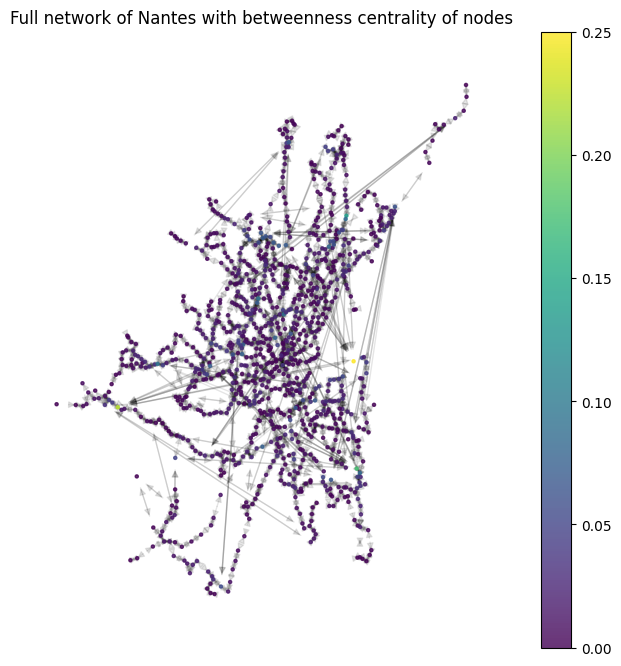

In [20]:
plt.subplots(figsize=(8, 8))
city_network = cities_graphs_dir["nantes"]["full"]

list_nodes =list(city_network.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 

pos = {}
node_lons = nx.get_node_attributes(city_network, "lon")
node_lats = nx.get_node_attributes(city_network, "lat")

for node, node_lon in node_lons.items():
    pos[node] = (node_lon, node_lats[node])

ec = nx.draw_networkx_edges(city_network, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(city_network, pos, node_size=20, nodelist=list_nodes, node_color=[city_network.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.title("Full network of Nantes with betweenness centrality of nodes")
plt.axis('off')
plt.show()

Here we see the important transfer stations, especially considering the full route, these stops represent the transist stations between different modes of transport.

`Luxembourg, Gare Centrale` in Luxembourg or the stops in Paris are either large stops or next to very busy stops.

Some stations have zero centrality, that is because the network has three stops or disconnected nodes. For example, Berlin has three ferry routes between two different nodes each.

As it is difficult to visualise large networks, we visualise Winnipeg and Nantes. The nodes in yellow have the highest betweenness cenrtality. As the bus routes dominate the other routes types across all cities, it is natural that are prominent when considering the transport network of the whole city.


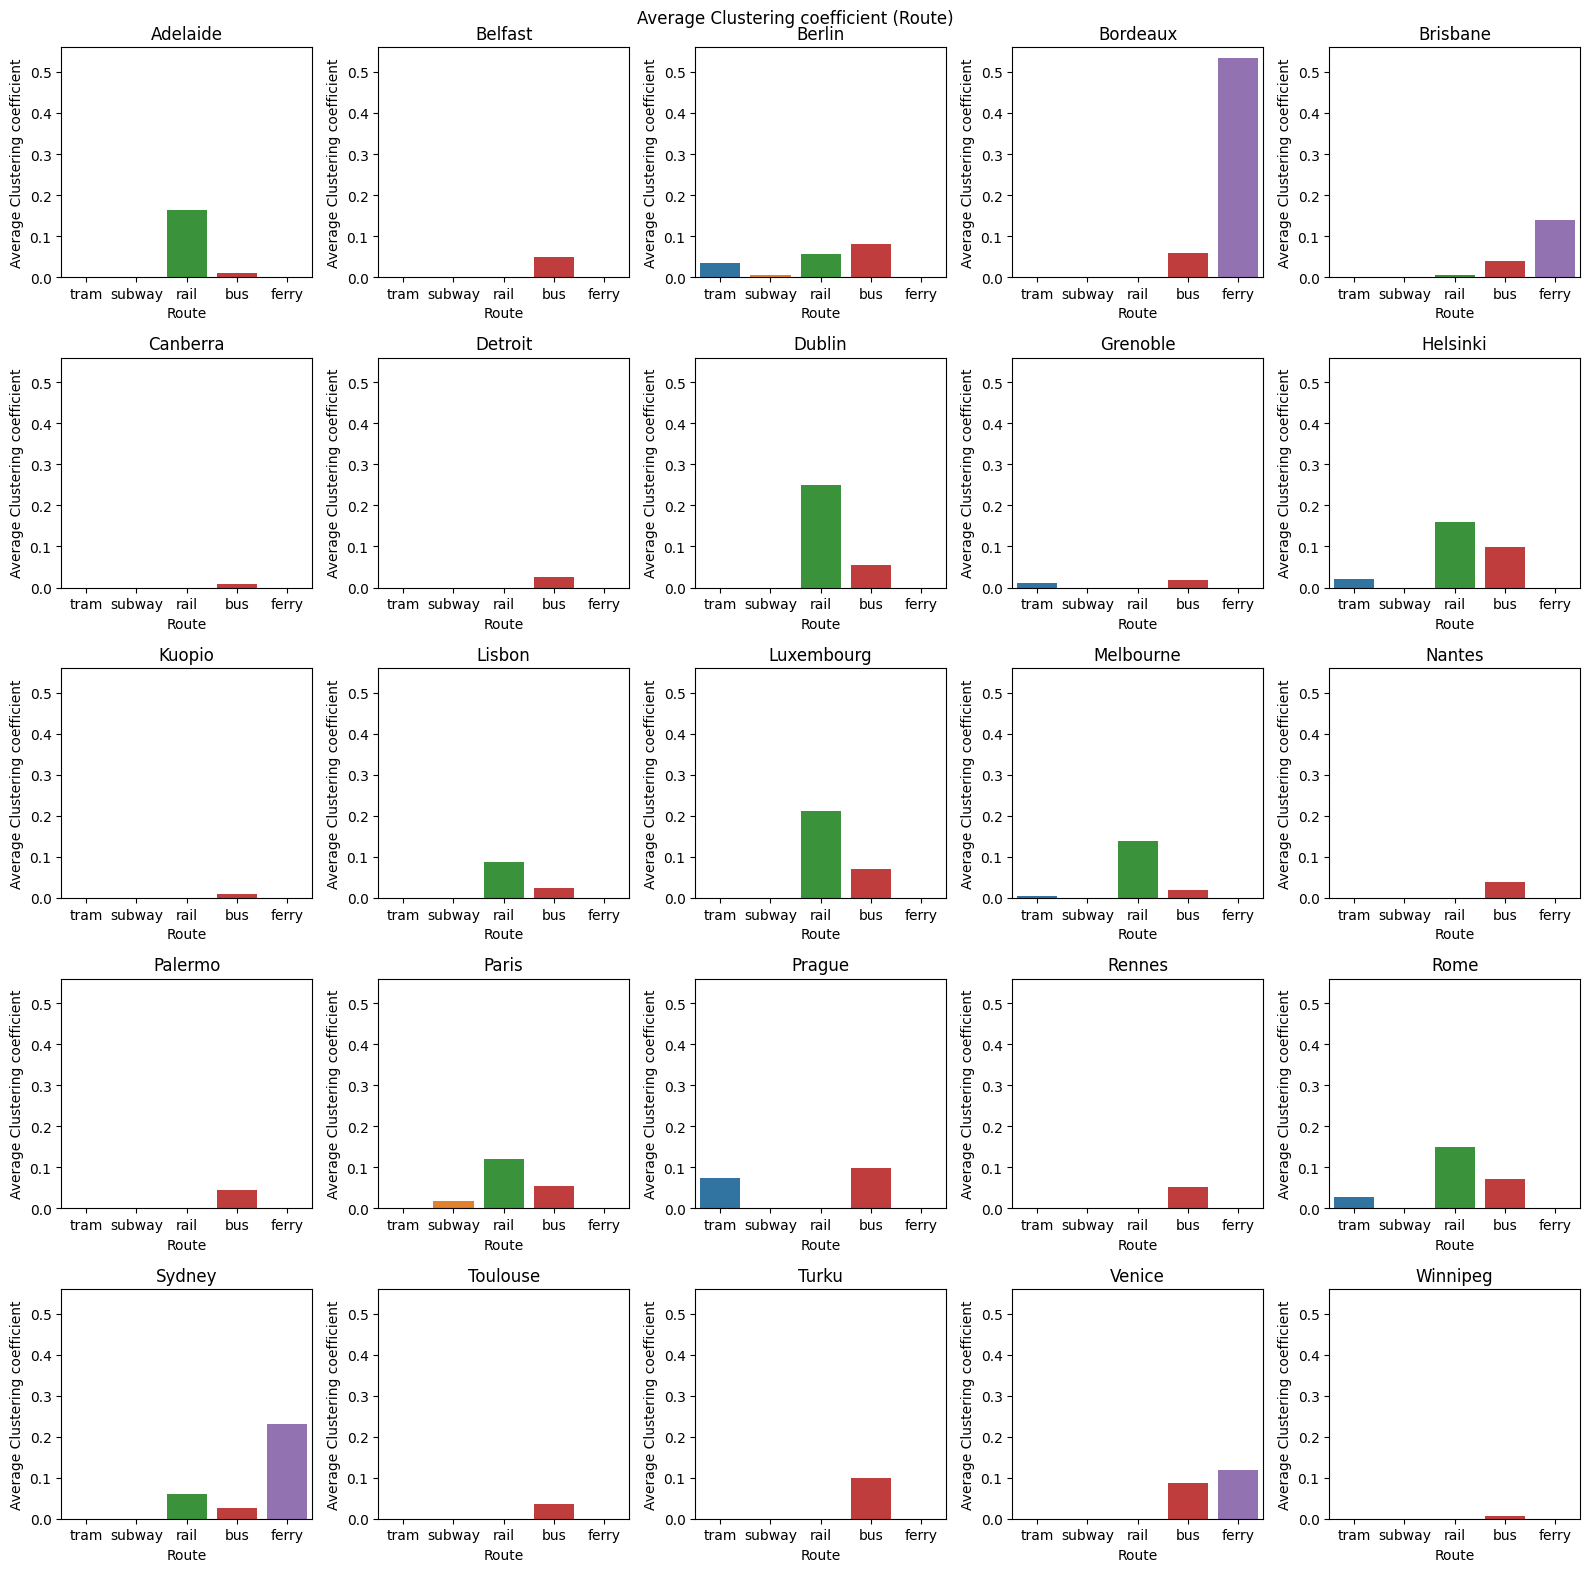

In [21]:
# Clustering coefficients across different cities, across different transport types
fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)

clustering_coeffs_cities = {}
for idx, (city, city_graphs) in enumerate(cities_graphs_dir.items()):
    clustering_coeffs_cities[city] = {}
    clustering_coeffs = {}
    for route_idx, (route_label, route_subgraph) in enumerate(city_graphs.items()):
        if route_label in ["cablecar", "full"]:
            continue
        elif route_subgraph is not None:
            avg_cc = nx.average_clustering(route_subgraph)
            clustering_coeffs_cities[city][route_label] = avg_cc
            clustering_coeffs[route_label] = avg_cc
        else:
            clustering_coeffs_cities[city][route_label] = np.nan
            clustering_coeffs[route_label] = np.nan
    
    row = int(idx / 5)
    col = idx % 5

    sns.barplot(x=list(clustering_coeffs.keys()), y=list(clustering_coeffs.values()), ax=axes[row][col])
    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Average Clustering coefficient")
    axes[row][col].set_xlabel("Route")
    # axes[row][col].set_yscale('log')
    axes[row][col].xaxis.set_tick_params(labelbottom=True)
    axes[row][col].yaxis.set_tick_params(labelbottom=True)

    # axes[row][col].legend()
    
fig.suptitle('Average Clustering coefficient (Route)')
fig.tight_layout()    

<Axes: >

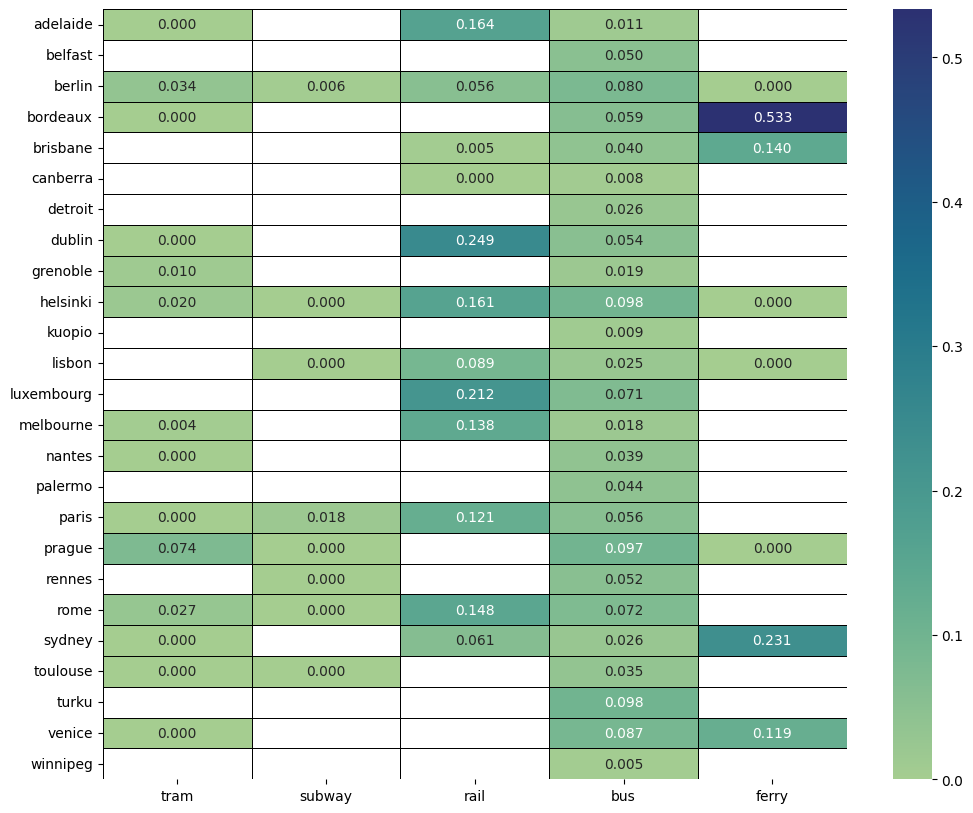

In [22]:
clustering_coeffs_df = pd.DataFrame(clustering_coeffs_cities).T

plt.figure(figsize=(12,10))
sns.heatmap(clustering_coeffs_df, cmap="crest", annot=True, fmt=".3f", linewidth=.5, linecolor='black')

For transport network, Average Clustering Coefficient (ACC) can provide insight into the local connectivity of the network and the degree to which transportation nodes are connected to each other. A high average clustering coefficient indicates that the nodes tend to be densely connected to each other, forming clusters or hubs. A low average clustering coefficient may indicate that transportation nodes in the network are more sparsely connected, potentially leading to longer travel times or more complicated travel routes for travelers.

From the above chart(s), almost all modes have low clustering coefficients. Some even have 0 ACC, indicating they have disconnected components such as the Berlin ferry route. As mentioned earlier, due to same stops or stops in same geographical location having different nodes also contributes to this low ACCs.

The rail and bus modes have greater ACC indicating that they are better connected than the other modes of transport.

From the above graphs, it is observed that cities with higher number of nodes and edges also posses a high clustering coefficient value in one or few of the modes of transport that they have.

This is observed for larger cities, for instance Paris, Sydney, and Berlin where the clustering coefficient of the city's popular mode of transport is `~ 0.1`, whereas in cities with lesser number of nodes and edges like Prague or Canberra, have a lower clustering coefficient even for it's most popular / connected mode of transport.

It is also observed that most cities have one (or rarely two) modes of transport with high clustering coefficient.


# TODO:- Review this part later

### Modeling city networks as a generation process

Looking at the degree distribution above, we concluded that it cannot be modelled by a random network model. Let us try modeling this network as a growth and / or preferential attachment based process using the Barabasi-Albert (BA) model to start with.

The BA model typically starts with an initial set of nodes $m_0$ and makes use of both growth and preferential attachment in developing the network.

At each iteration in the process,
Growth: Add a new node with $m <= m_0$ links that connects to `m` nodes in the existing network.
Preferential Attachment: The new nodes are attached to existing nodes in the network with the probabilities weighted according to the perferential attachment parameter $\pi_{k_{i}}$ which is defined by:
$\pi_{k_{i}} = \frac{k_{i}}{\sum\limits_{j=1}^{N}k_{j}}$
Where $\pi_{k_{i}}$ denotes the probability that a new node will get attached to node 'i' via an edge.

For the choice of the hyperparameter `m`, we make use of this expression

`[To-do: Review if it's the right choice]`
$m = \frac{\Sigma_{i=1}^N degree_{i}}{N}$

where `N` is the number of nodes

Let us consider modelling the two cities, Paris and Sydney with a large number of nodes and edges with the BA model first.


In [23]:
def compare_with_BA_model(graph, city_name, m0=10):
    """
    Simulate a Barabasi-Albert network to model the city network
    and compare it with the original city_network's properties

    Args:
        graph: nx.MultiDiGraph -> Network for a city
        city_name: str -> Name of the city to consider
        m0: int -> Initial number of nodes to have in the network generation process
    """
    # Degree distribution of the city network
    degrees_G = np.array([graph.degree(node) for node in graph.nodes()])
    m = round(sum(degrees_G)/len(degrees_G))
    
    # Barabasi Albert graph
    model_G = nx.barabasi_albert_graph(len(graph.nodes), m)
    degrees_ba_model = np.array([model_G.degree(node) for node in model_G.nodes()])
    
    # Plot degree distributions of both networks for comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
    axes[0].set_title("{}: City network degrees".format(city_name))
    axes[0].hist(degrees_G, bins=np.arange(np.max(degrees_G)))
    axes[1].set_title("BA model degrees")
    axes[1].hist(degrees_ba_model, bins=np.arange(np.max(degrees_G)))

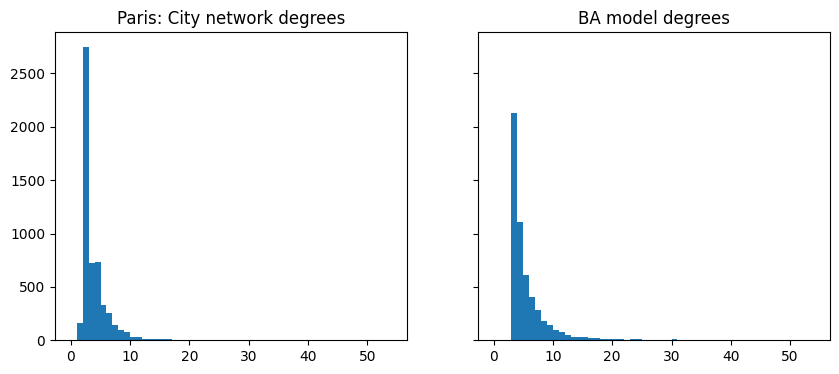

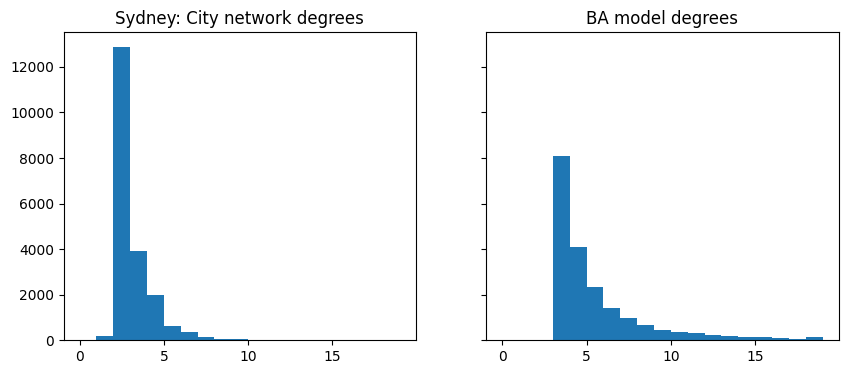

In [24]:
city_name = "Paris"
city_G = cities_graphs_undir[city_name.lower()]['full']
compare_with_BA_model(graph=city_G, city_name=city_name, m0=10)

# Comparison for another city: Sydney
city_name = "Sydney"
city_G = cities_graphs_undir[city_name.lower()]['full']
compare_with_BA_model(graph=city_G, city_name=city_name, m0=10)

Next, we consider modeling two cities with lesser number of nodes and edges with the network generation model.
The cities Prague and Winnipeg are considered here.


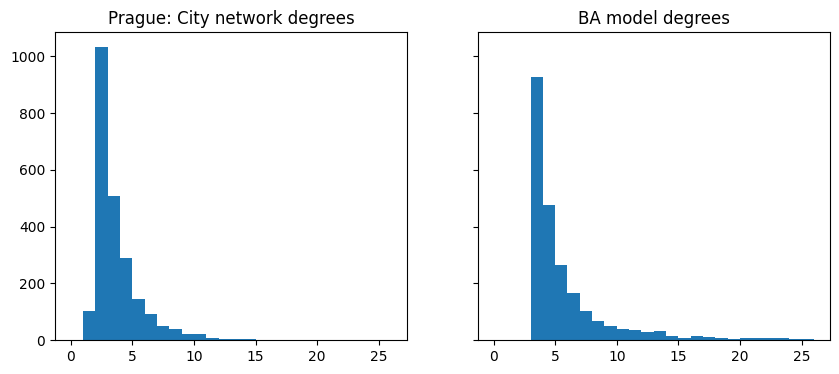

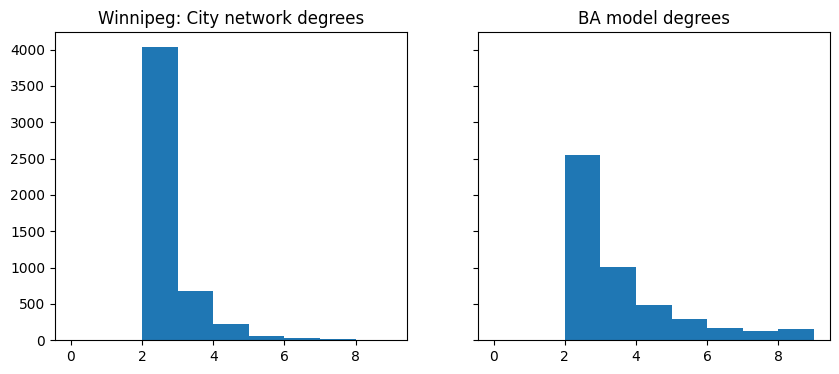

In [25]:
# Comparision for the BA model with cities Prague and Winnipeg.
city_name = "Prague"
city_G = cities_graphs_undir[city_name.lower()]['full']
compare_with_BA_model(graph=city_G, city_name=city_name, m0=10)

city_name = "Winnipeg"
city_G = cities_graphs_undir[city_name.lower()]['full']
compare_with_BA_model(graph=city_G, city_name=city_name, m0=10)

For all the cities considered above, we observe that the Barabasi Albert model provides a reasonably good approximation to model the nature of degree distritbutions of the nodes in the network. For cities with large number of nodes and edges, like Paris and Sydney, there is a steeper reduction in the number of nodes with the increase in the node degree and in smaller cities like Pargue and Winnipeg, the reduction is more gradual. It is possible that transport network for larger cities (in terms of nodes / edges) have higher preferential attachment factor that is superlinear in terms of node degree. The BA-model which applies a linear preferential attachment has a less steeper reduction in the number of nodes for higher degrees. It is fair to reason that city transport networks can be modelled as a generation process considering both growth and superlinear attachment features.


In [ ]:
# Extract node-level features
# Consider hand-crafted features first
feature_names = ["degree", "betweenness", "closeness", "eigenvector"]
def node_feature_extraction(graph):
    # compute node degrees
    degree_dict = dict(graph.degree())
    # Compute node betweenness centrality
    betweenness_dict = nx.betweenness_centrality(graph)
    # Compute closeness centrality
    closeness_dict = nx.closeness_centrality(graph)
    # Compute eigenvector centrality
    eigenvector_dict = nx.eigenvector_centrality(graph)
    # Compute clustering coefficient
    clustering_dict = nx.clustering(graph)

    # Combine the hand-crafted features into a single array
    features = np.array([[degree_dict[node], betweenness_dict[node], closeness_dict[node] , eigenvector_dict[node], clustering_dict[node]] for node in graph.nodes()])

    return features

In [ ]:
from node2vec import Node2Vec
# Node2Vec feature extraction function
def Node2Vec_node_feature_extraction(G, num_features=1, p=1.0, q=1.0, seed=0):
    """
    Extract the node2vec features from the graph

    Args:
    G: nx.Graph -> Graph input
    num_features: int -> dimensions of the node embeddings
    p: float -> return parameter, explains the likelihood of immediately revisiting a particular node
    q: float -> in-out parameter, allows search to differentiate between "inward" and "outward" nodes
    seed: please always set to 0

    Returns:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
    """

    node2vec_ = Node2Vec(G, dimensions=num_features, p=p, q=q, seed=seed)
    model = node2vec_.fit()
    features = np.array([model.wv[node] for node in G.nodes()])
    return features

In [37]:
def compute_laplacian(adjacency: np.ndarray, normalize: str):
    """
    Computes the laplacian of a graph, given it's adjacency matrix

    Args:
      adjacency: np.ndarray -> The adjacency matrix of the graph
      normalize: str (None | 'sym' |'rw') for the combinatorial, symmetric normalized or random walk Laplacians

    Returns:
      L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """

    degree_matrix = np.diag(np.sum(adjacency, axis=0).reshape(-1))
    L = degree_matrix - adjacency

    if normalize is None:
       # Combinatorial Laplacian L = D - A
       pass
    elif normalize == "sym":
        # Symmetric normalized Laplacian L = D^(-1/2) L D^(-1/2)
        degree_matrix_sqrt_inv = np.sqrt(np.linalg.inv(degree_matrix))
        L = np.dot(np.dot(degree_matrix_sqrt_inv, L), degree_matrix_sqrt_inv)

    elif normalize == "rw":
        # Random walk Laplacian L = D^(-1) L
        inv_degree_matrix = np.linalg.inv(degree_matrix)
        L = np.dot(inv_degree_matrix, L)
    else:
        raise ValueError(f'Unknown normalization: {normalize}')
    return L

In [38]:
# Function to get the spectral decomposition of a matrix (laplacian matrix in our case)
def spectral_decomposition(laplacian: np.ndarray):
    """
    Computes the spectral decomposition of a given laplacian matrix

    Args:
        laplacian: np.ndarray -> Input laplacian of the graph
    
    Returns: (np.array, np.ndarray) ->
        eigenvalues (np.array): eigenvalues of the Laplacian
        eigenvectors (np.ndarray): corresponding eigenvectors.
    """
    eigenvalues, eigenvectors = np.linalg.eig(laplacian)
    return eigenvalues, eigenvectors

In [40]:
class SpectralClustering():
    """
    Implements clustering of the nodes in a graph, by making use
    of it's spectral features.
    """
    def __init__(self, n_classes: int, normalize: str):
        """
        Method for initialisation.
        
        Args:
            n_classes: int -> The number of clusters to consider for the clustering
            normalize: str (None | 'sym' | 'rw' ) -> for the combinatorial, symmetric normalized or random walk Laplacians (for spectral features)
        """
        self.n_classes = n_classes
        self.normalize = normalize
        self.clustering_method = KMeans(n_clusters=n_classes, random_state=0, n_init="auto")
        
    def fit_predict(self, G: nx.Graph):
        """
        Compute cluster predictions for the nodes of the graph

        Args:
            G: (nx.Graph | nx.DiGraph | nx.MultiDiGraph) -> Graph (N, E) input for node clustering
            
        Returns:
            y_pred (np.ndarray (N x n_classes)): cluster assignments to each node of the graph
        """
        # Compute the laplacian from the graph's adjacency matrix
        laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
        # Get eigenvectors corresponding to the k-smallest eigenvalues.
        eigenvalues, eigenvectors = spectral_decomposition(laplacian)
        indices = np.argsort(eigenvalues)[0:self.n_classes]
        spectral_features = eigenvectors[:, indices]
        spectral_features = np.real_if_close(spectral_features, tol=1)

        y_pred = self.clustering_method.fit_predict(spectral_features)
        return y_pred

In [47]:
def visualise_clusters(graph, labels, node_list, edges_same, edges_different, size_args, ax=None):
    """
    Plots the nodes of a graph with node-colors indicating the cluster a particular node belongs to.

    Args:
        graph: (nx.Graph | nx.DiGraph | nx.MultiDiGraph) -> graph to visualise
        labels: np.array -> array of cluster labels
        node_list: dict() -> map of cluster labels  :=> set of node ids belonging to the cluster
        edges_same: list -> collection of edge tuples belonging to the same cluster
        edges_different: list -> collection of edge tuples with it's two nodes belonging to differnt clusters  
        size_args: dict() -> Arguments to specify for size aspects of the figure to draw.
        ax: (Matplotlib Axes object, optional) -> Axis to use instead of the entire figure.

    Returns:
        Visualisation of the node clusters
    """
    cm = plt.cm.tab20
    # pos = nx.spring_layout(graph, seed=0)
    pos = {}
    node_lons = nx.get_node_attributes(graph, "lon")
    node_lats = nx.get_node_attributes(graph, "lat")

    for node, node_lon in node_lons.items():
        pos[node] = (node_lon, node_lats[node])
    
    if ax is None:
        plt.figure(figsize=size_args['fig_dims'])
    for cluster_label in labels:
        nx.draw_networkx_nodes(graph, pos, nodelist=list(node_list[cluster_label]), node_color=cm(cluster_label), node_size=size_args['node_size'], alpha=0.8, ax=ax)
        nx.draw_networkx_edges(graph, pos, edgelist=edges_same[cluster_label], width=size_args['edge_width'], alpha=0.5, edge_color=cm(cluster_label), ax=ax)
    nx.draw_networkx_edges(graph, pos, edgelist=edges_different, width=size_args['edge_width'], alpha=0.5, edge_color="tab:gray", ax=ax)

In [42]:
def get_edge_partitions_from_clusters(graph, n_classes, node_clusters):
    """
    Paritition the edge list into edges with nodes belonging to the same cluster
    and edges with nodes belonging to different clusters.

    Args:
        graph: (nx.Graph | nx.DiGraph | nx.MultiDiGraph) -> graph with N nodes and E edges
        n_classes: int -> Number of clusters
        node_clusters: np.array (N, ) -> Array of indices indicating the cluster
            each node of graph belongs to.
    
    Returns:
        partitions: dict with keys ("labels", "node_list", "edges_same", "edges_different", "stats") ->
            "labels"            -> list, cluster labels
            "node_list"         -> map of cluster label :=> set of nodes belonging to this cluster
            "edges_same"        -> collection of edge tuples belonging to the same cluster
            "edges_different"   -> collection of edge tuples with it's two nodes belonging to different clusters
            "stats"             -> dictionary() with keys "n_same", "n_diff" for total number of edges in same / different clusters
    """

    # Construct a map from a cluster label -> set of graph nodes predicted for this label
    labels = np.arange(n_classes)
    graph_nodes = list(graph.nodes())
    node_list = {}
    for idx, val in enumerate(node_clusters):
        if val not in node_list:
            node_list[val] = set()
        node_list[val].add(graph_nodes[idx])

    # Load the edges between nodes with same/different labels into lists
    edge_list_same = [[(s, d) for (s, d) in graph.edges() if s in node_list[l] and d in node_list[l]] for l in labels]
    edge_list_same_all = []
    for l in labels:  
        edge_list_same_all += edge_list_same[l]
    edge_list_diff = [(s, d) for (s, d) in graph.edges() if (s, d) not in edge_list_same_all]

    return {
        "labels": labels,
        "node_list": node_list,
        "edges_same": edge_list_same,
        "edges_different": edge_list_diff,
        "stats": {
            "n_same": len(edge_list_same_all),
            "n_diff": len(edge_list_diff)
        }
    }

In [43]:
def get_number_of_clusters(graph):
    """
    Function that computes the number of clusters to consider for a graph based on
    it's connectivity. The objective attempts to maximise the number of clusters to use,
    while minimising (heavily) the number of edges with nodes belonging to different clusters.

    Args:
        graph: (nx.Graph | nx.DiGraph | nx.MultiDiGraph) -> graph
    
    Returns:
        num_clusters: int -> The number of clusters to consider for the graph
    """
    low = 1 
    bounds = min(len(graph.nodes), len(graph.edges)) - 1
    high = min(20, bounds)
    # Binary search for this optimal value
    while low <= high:
        mid = int( (low + high) / 2)
        spectral_clustering = SpectralClustering(n_classes=mid, normalize="rw")
        node_clusters = spectral_clustering.fit_predict(graph)
        graph_partitions = get_edge_partitions_from_clusters(graph=graph, n_classes=mid, node_clusters=node_clusters)
        if graph_partitions['stats']['n_diff'] == 0:
            low = mid + 1
        else:
            high = mid - 1

    return mid


In [44]:
def plot_clusters(graph, city_node_clusters, n_classes, size_args=None):
    """
    Plots the nodes of a graph with node-colors indicating the cluster a particular node belongs to.

    Args:
    graph: (nx.Graph | nx.MultiDiGraph) (num_nodes: N, num_edges: E) -> The city network graph
    city_node_clusters: np.ndarray (N, ) -> Array of indices indicating the cluster
      each node of graph belongs to.
    n_classes: int -> Number of clusters
    """
    pass
    # Ideally the number of clusters are chosen to minimize the number of edges among nodes belonging to different clusters
    # and number of nodes belonging to the same cluster

/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/Users/ravinithesh/miniconda3/envs/nml/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


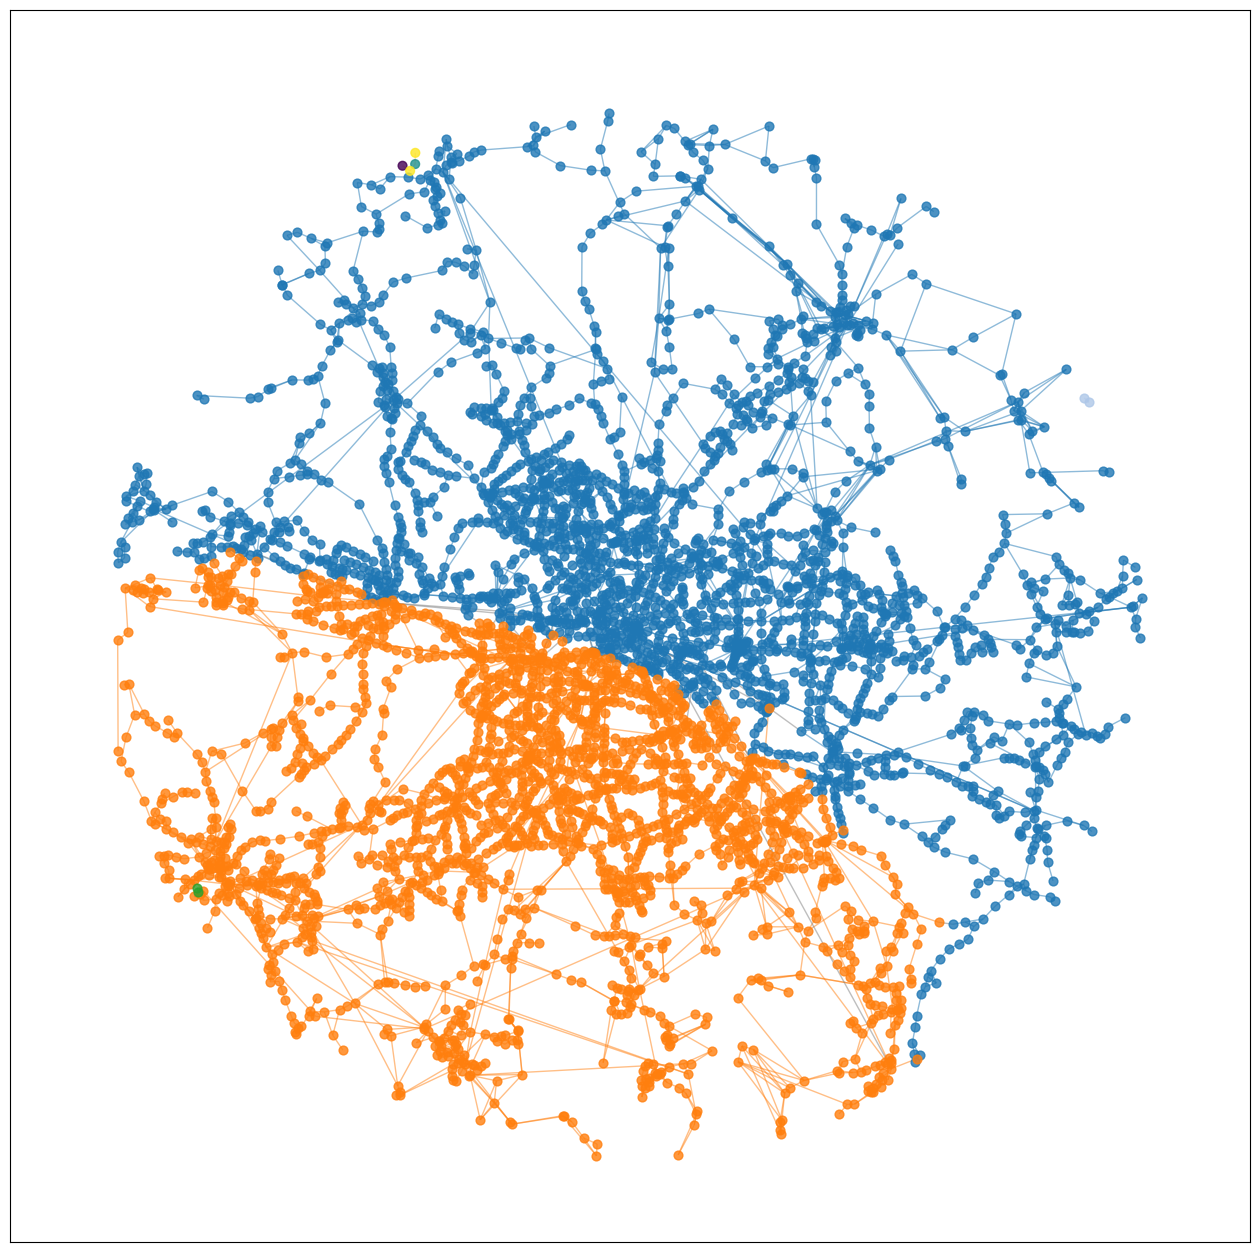

In [50]:
# Consider the city: Berlin for the node clustering task
city_name = "Berlin"
city_G = cities_graphs_undir[city_name.lower()]['full']

n_clusters = 5
spectral_clustering = SpectralClustering(n_classes=n_clusters, normalize="rw")
node_clusters = spectral_clustering.fit_predict(city_G)
partitions = get_edge_partitions_from_clusters(graph=city_G, n_classes=n_clusters, node_clusters=node_clusters)
visualise_clusters(
    city_G,
    labels=partitions['labels'],
    node_list=partitions['node_list'],
    edges_same=partitions['edges_same'],
    edges_different=partitions['edges_different'],
    size_args={
        'fig_dims': (16, 16),
        'node_size': 40,
        'edge_width': 1.0
    })
#city_node_clusters = spectral_clustering.fit_predict(city_G)
#plot_clusters(city_G=city_G, city_node_clusters=city_node_clusters, n_classes=8)

# TODO:- Review this

The above clustering visualization represents that for the city Berlin, most of the nodes in it's transport network are well connected, at least by one mode of transport. The well connected nodes present in the central part of this visualisation represents the places in the city that are connected by multiple modes of transport types, and to a large number of other places as well. Nodes that have lesser connectivity in terms of neighbours and parallel edges (across multiple transport types), are grouped into clusters that could be observed in the periphery of the visualisation with the colors (orage, and blue). Some places in the city are disconnected from the highly connected nodes in the center as well as the majority of the other nodes are grouped into unique clusters as well (for instance, nodes colored with green / yellow).

Number of transport types in the city network 5


/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = comp

4


/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = comp

Optimal number of clusters for tram = 4


/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/Users/ravinithesh/miniconda3/envs/nml/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/

Optimal number of clusters for subway = 4
Optimal number of clusters for rail = 3


/Users/ravinithesh/miniconda3/envs/nml/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/

Optimal number of clusters for bus = 4


/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/Users/ravinithesh/miniconda3/envs/nml/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_10741/680723582.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
/var/

Optimal number of clusters for ferry = 3


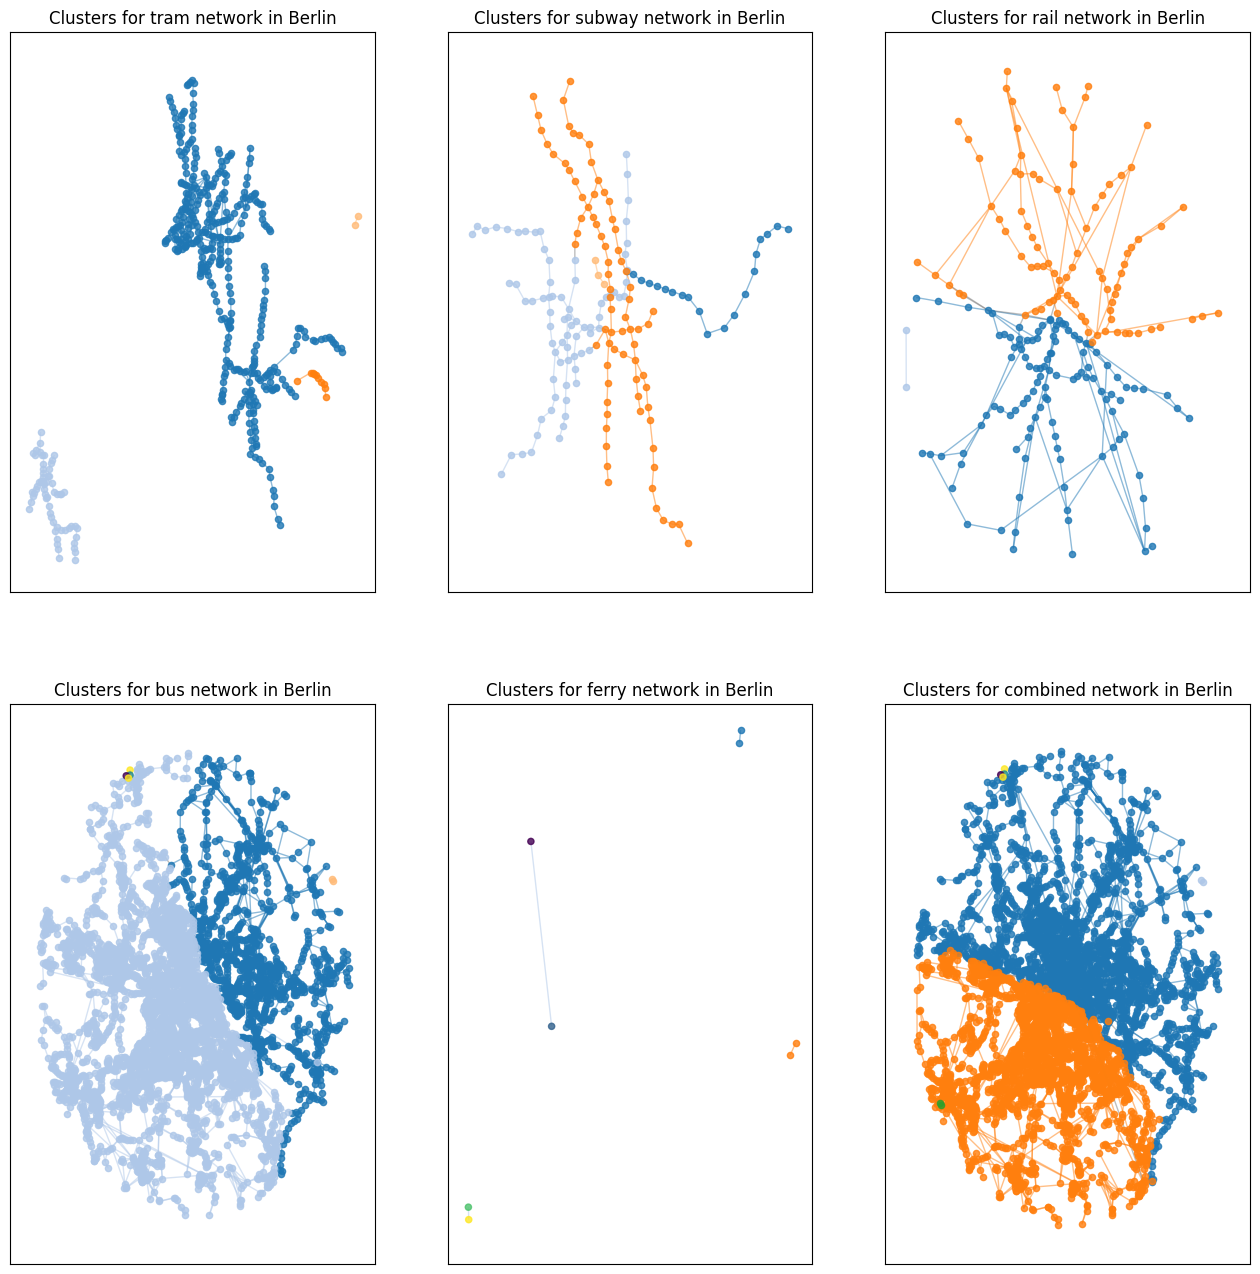

In [55]:
# Consider clustering for different transport types for this city
transport_types = []
for route_type, route_graph in cities_graphs_undir[city_name.lower()].items():
    # Ignore the full network
    if ((route_type in ["full"]) or (route_graph is None)):
        continue
    transport_types.append(route_type)
print("Number of transport types in the city network {}".format(len(transport_types)))
fig, axes = plt.subplots(2, 3, figsize=(16, 16))
print(get_number_of_clusters(cities_graphs_undir[city_name.lower()][transport_type] ))
# Visualise node clusters obtained from across different types of transports the city has.
for idx, transport_type in enumerate(transport_types):
    route_subgraph = cities_graphs_undir[city_name.lower()][transport_type]
    # Get the optimal number of clusters for this subgraph
    n_clusters_opt = get_number_of_clusters(route_subgraph)
    print("Optimal number of clusters for {} = {}".format(transport_type, n_clusters_opt))

    # Spectral clustering
    spectral_clustering = SpectralClustering(n_classes=n_clusters_opt, normalize="rw")
    route_clusters = spectral_clustering.fit_predict(route_subgraph)
    route_partitions = get_edge_partitions_from_clusters(route_subgraph, n_clusters_opt, route_clusters)

    # Plot the clusters obtained
    row = int(idx / 3)
    col = idx % 3

    axes[row][col].set_title("Clusters for {} network in {}".format(transport_type, city_name))
    visualise_clusters(
        graph=route_subgraph,
        labels=route_partitions['labels'],
        node_list=route_partitions['node_list'],
        edges_same=route_partitions['edges_same'],
        edges_different=route_partitions['edges_different'],
        size_args={ 'fig_dims': (8, 8), 'node_size': 20, 'edge_width': 1.0 },
        ax=axes[row][col]
    )
# Have the last one for the combined network
axes[1][2].set_title("Clusters for combined network in {}".format(city_name))
visualise_clusters(
    city_G,
    labels=partitions['labels'],
    node_list=partitions['node_list'],
    edges_same=partitions['edges_same'],
    edges_different=partitions['edges_different'],
    size_args={ 'fig_dims': (8, 8), 'node_size': 20, 'edge_width': 1.0 },
    ax=axes[1][2]
)


For Berlin, the above visualisation represents the node clusters for the subgraphs corresponding to the different transport types in the city. The network for each transport type can be very different from another type. For instance, the bus network has a large number of interconnected nodes such that most of the bus stops are reachable from each other through a route. On the other hand, the ferry network has only 8 nodes and 4 edges and have 4 disconnected components.

In the K-Means clustering algorithm, the choice of K (number of clusters) is a hyperparameter and from the above observation, it would not be ideal to choose the same value of K for all of these transport subgraphs. Hence, the optimal number of clusters are calculated by figuring out the value of `K` for which the below conditions are satisfied:

Chosen value of `K` for KMeans clustering attempts to:

1. Minimise the number of edges that have nodes belonging to different clusters.
2. Maximise the number of edges that have nodes belonging to the same cluster.
3. Maximise the value of `K` given that conditions 1 and 2 are met.

For instance, if K is selected as 1 (trivially), all nodes are grouped into one cluster and conditions 1 and 2 are trivially satisfied. However, we don't want to consider $K=1$ as it doesn't provide any useful insights. For condition 3, we search through possible values of K using binary search and measure the number of edges belonging to different / same clusters to guide the search process.


###
